# <b> <font color='#A20025'> 📚 Chapter 9: Structure-based Drug Design with Active Learning


*This notebook contains the code examples in chapter 9. For readability, the chapter notebooks only contain runnable code blocks and section titles. They omit the rest of the material in the book, i.e., text paragraphs, figures (unless generated as part of one of the code blocks), equations, and pseudocode. I recommend reading the notebooks side-by-side with the book!*

You can work through this notebook locally as well as via Google Colab:
<a target="_blank" href="https://colab.research.google.com/github/nrflynn2/ml-drug-discovery/blob/main/CH09_FLYNN_ML4DD.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This chapter covers:
- How three-dimensional protein structures can be leveraged to guide rational drug design through computational modeling of protein-ligand interactions. 
- Implementing a complete protein-ligand docking workflow to predict and evaluate how small molecules bind to target proteins. 
- Using deep learning approaches to create surrogate models that dramatically accelerate virtual screening of ultra-large compound libraries. 
- Building active learning systems that efficiently identify promising drug candidates while minimizing computational resources. 
- Extending active learning techniques to more rigorous binding affinity predictions with free energy perturbation for lead optimization.


## <b> <font color='#A20025'> ⚙️ Environment Setup

**❗️LOCAL ENVIRONMENT:** If you are running the Python notebook locally on your computer, then we recommend following the README setup instructions on how to use conda (or a similar package) to set up an environment using the file `ml4dd2025.yml`

**❗️COLAB ENVIRONMENT:** If you are running the code via an instance on Google Colab, you can download the necessary files and create the environment by running the following cells marked as **Colab users only**.

In [ ]:
# Colab users only
import os
CHAPTER = "ch09"
os.makedirs(f"artifacts/{CHAPTER}", exist_ok=True)
os.makedirs(f"data/{CHAPTER}", exist_ok=True)
os.makedirs(f"figures/{CHAPTER}", exist_ok=True)
!wget data...
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/data/ch09/4AG8_docking.csv" -O "data/ch09/4AG8_docking.csv"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/data/ch09/6vhn_prepared.pdb" -O "data/ch09/6vhn_prepared.pdb"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/data/ch09/6vhn.pdb" -O "data/ch09/6vhn.pdb"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/data/ch09/ligand.pdb" -O "data/ch09/ligand.pdb"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/data/ch09/Enamine_Hinge_Binders_Library.sdf.gz" -O "data/ch09/Enamine_Hinge_Binders_Library.sdf.gz"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/ml4dd2025.yml" -O "env.yml"

In [ ]:
# Colab users only
!pip install -q condacolab
import condacolab
condacolab.install() #  The kernel will restart after this cell has run, which is normal.

In [ ]:
# Colab users only
# Verify condalab installation
import condacolab
condacolab.check()

In [ ]:
# Colab users only
# We can only use the base environment in `condacolab`, so we will update it with the `env.yml` file we downloaded earlier.
!mamba env update -n base -f env.yml

### <b> <font color='#A20025'> Import Packages 

Now let's import all the packages we'll need for this chapter.

In [2]:
# Standard library imports
import copy
import datetime
import json
import math
import os
import shutil
import tempfile
import time
from concurrent.futures import ProcessPoolExecutor, as_completed
from dataclasses import dataclass
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

# Third-party scientific computing and data analysis
import numpy as np
import pandas as pd
from tqdm import tqdm

# Visualization libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Deep learning with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

# Molecular modeling and cheminformatics
import mdtraj
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.SimDivFilters import rdSimDivPickers

# Molecular docking and protein-ligand interaction
import prolif as plf
from meeko import MoleculePreparation, PDBQTWriterLegacy
from vina import Vina

# Conditionally imported libraries with error handling
try:
    from openbabel import pybel
except ImportError:
    raise ImportError("OpenBabel and Pybel are required for this script.")

# Protein structure preparation tools
try:
    from pdbfixer import PDBFixer
    from openmm.app import PDBFile
except ImportError:
    raise ImportError("PDBFixer and OpenMM are required to fix the protein structure.")

/home/nflynn/anaconda3/envs/ml4dd2025/lib/python3.12/site-packages/MDAnalysis/topology/tables.py:52: DeprecationWarning: Deprecated in version 2.8.0
MDAnalysis.topology.tables has been moved to MDAnalysis.guesser.tables. This import point will be removed in MDAnalysis version 3.0.0
  warnings.warn(wmsg, category=DeprecationWarning)


In [10]:
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)


In [4]:
# Matplotlib and Seaborn setup for consistent visualizations
def setup_visualization_style():
    """Configure consistent visualization style for the notebook"""
    colors = ["#A20025", "#6C8EBF", "#F9CBCD", "#D4E1F5", "#A680B8", "#C3ABD0", "#12AAB5", "#9AC7BF"]  
    sns.set_palette(sns.color_palette(colors))
    plt.rcParams['axes.titlesize'] = 18
    plt.rcParams['axes.labelsize'] = 16
    plt.rcParams['legend.fontsize'] = 16   
    plt.rcParams['xtick.labelsize'] = 16   
    plt.rcParams['ytick.labelsize'] = 16    

setup_visualization_style()
%matplotlib inline

In [5]:
# RDKit drawing setup
def setup_rdkit_drawing():
    """Configure RDKit drawing settings for consistent molecular visualizations"""
    d2d = Draw.MolDraw2DSVG(-1, -1)
    dopts = d2d.drawOptions()
    dopts.useBWAtomPalette()
    dopts.setHighlightColour((.635, .0, .145, .4))
    dopts.baseFontSize = 1.0
    dopts.additionalAtomLabelPadding = 0.15
    return dopts

rdkit_drawing_options = setup_rdkit_drawing()

## <b> <font color='#A20025'> 1️⃣ Structure-based Drug Design

Structure-based drug design (SBDD) leverages knowledge of the 3D structure of biological targets to guide drug development. In this section, we'll implement a molecular docking workflow to evaluate how compounds bind to a protein target.
 
First, let's set up our directory structure and define our input/output paths:

In [6]:
# Set up directories for this experiment
CHAPTER = "ch09"
exp_name = "docking_experiment"
input_dir = f"artifacts/{CHAPTER}/{exp_name}/inputs"
output_dir = f"artifacts/{CHAPTER}/{exp_name}/outputs"
os.makedirs(input_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

# Define paths for our protein and ligand files
raw_pdb_file = f"data/{CHAPTER}/6vhn.pdb"
receptor_file = f"data/{CHAPTER}/receptor.pdb"
ligand_file = f"data/{CHAPTER}/ligand.pdb"
fixed_receptor_file = f"data/{CHAPTER}/6vhn_prepared.pdb"

# Define paths for our docking input and output files
ligand_sdf = os.path.join(input_dir, "ligand.sdf")
receptor_pdbqt = os.path.join(input_dir, "receptor.pdbqt")
ligand_pdbqt = os.path.join(input_dir, "ligand.pdbqt")
docking_output_file = os.path.join(output_dir, "ligand_out.pdbqt")

 ### <b> <font color='#A20025'> Protein-Ligand Preparation

Now let's implement the classes and functions that will help us prepare our protein and ligand molecules for docking. First, we'll define a configuration class and helper classes for molecule preparation:

In [6]:
class MoleculePreparationConfig:
    """Configuration for molecule preparation.
    
    Attributes:
        add_hydrogens: Whether to add hydrogen atoms to the molecule.
        make_3d: Whether to generate 3D coordinates for the molecule.
        charge_model: The partial charge model to use (e.g., "gasteiger").
    """
    def __init__(self, add_hydrogens=True, make_3d=True, charge_model="gasteiger"):
        self.add_hydrogens = add_hydrogens
        self.make_3d = make_3d
        self.charge_model = charge_model

class MoleculeReader:
    """Reads molecule data from files."""
    @staticmethod
    def read_molecule(file: Union[str, os.PathLike], file_format: str = "pdb") -> List[pybel.Molecule]:
        """Reads molecules from a file.
        
        Args:
            file: The path to the molecule file.
            file_format: The format of the molecule file (e.g., "pdb", "sdf").
            
        Returns:
            A list of pybel.Molecule objects.
        """
        return list(pybel.readfile(format=file_format, filename=file))

class MoleculePreparator:
    """Prepares molecules for docking, including adding hydrogens, generating 3D coordinates, and calculating charges."""
    def __init__(self, config: MoleculePreparationConfig = MoleculePreparationConfig()):
        self.config = config

    def prepare_molecule(self, molecule: pybel.Molecule) -> pybel.Molecule:
        """Prepares a single molecule for docking.
        
        Args:
            molecule: The pybel.Molecule object to prepare.
            
        Returns:
            The prepared pybel.Molecule object.
        """
        if self.config.add_hydrogens:
            molecule.addh()
        if self.config.make_3d and not molecule.OBMol.HasNonZeroCoords():
            molecule.make3D(forcefield="mmff94s", steps=10000)
        molecule.calccharges(model=self.config.charge_model)
        return molecule

    def save_molecule(self, molecule: pybel.Molecule, outpath: Union[str, os.PathLike], 
                      out_format: str = "pdbqt", overwrite: bool = False, rigid: bool = False) -> None:
        """Saves a molecule to a file.
        
        Args:
            molecule: The pybel.Molecule object to save.
            outpath: The path to the output file.
            out_format: The format of the output file (e.g., "pdbqt").
            overwrite: Whether to overwrite the output file if it exists.
            rigid: Whether to save the molecule as rigid (for docking).
        """
        if rigid:
            opt = {"r": None, "c": None, "h": None}  # rigid, compute charges, add hydrogens
        else:
            opt = {"b": None, "p": None, "h": None}  # flexible bonds, pH correction, add hydrogens
            
        with pybel.Outputfile(format=out_format, filename=str(outpath), overwrite=overwrite, opt=opt) as out:
            out.write(molecule)

Next, let's implement a `Preprocessor` class that handles the preparation of protein and ligand structures for docking:

In [7]:
class Preprocessor:
    """Handles the preparation of receptor and ligand molecules for docking."""
    def __init__(self, config: MoleculePreparationConfig = MoleculePreparationConfig(), fix_protein: bool = False):
        self.preparator = MoleculePreparator(config)
        self.fix_protein = fix_protein

    def _fix_receptor_structure(self, receptor_path: str, output_path: str) -> str:
        """Fixes the protein structure using PDBFixer.
        
        Args:
            receptor_path: Path to the input receptor PDB file.
            output_path: Path to save the fixed protein structure.
            
        Returns:
            Path to the fixed protein structure.
        """
        print("Fixing protein structure with PDBFixer...")
        fixer = PDBFixer(filename=receptor_path)
        
        # Find and fix missing residues
        fixer.findMissingResidues()
        
        # Find and replace non-standard residues
        fixer.findNonstandardResidues()
        fixer.replaceNonstandardResidues()
        
        # Remove heterogens (non-protein molecules, e.g., ligands, water)
        fixer.removeHeterogens(keepWater=False)
        
        # Find and add missing atoms
        fixer.findMissingAtoms()
        fixer.addMissingAtoms()
        
        # Add hydrogens at physiological pH (7.4)
        fixer.addMissingHydrogens(7.4)
        
        # Write the fixed structure to file
        PDBFile.writeFile(fixer.topology, fixer.positions, open(output_path, 'w'))
        print(f"Fixed protein structure saved to: {output_path}")
        return output_path
    
    def prepare_receptor(self, receptor_path: Union[str, os.PathLike], 
                         output_path: Union[str, os.PathLike]) -> None:
        """Prepares the receptor molecule for docking.
        
        Args:
            receptor_path: The path to the receptor file.
            output_path: The path to save the prepared receptor.
        """
        fixed_receptor_path = receptor_path
        if self.fix_protein:
            fixed_receptor_path = os.path.splitext(receptor_path)[0] + "_fixed.pdb"
            fixed_receptor_path = self._fix_receptor_structure(receptor_path, fixed_receptor_path)

        molecules = MoleculeReader.read_molecule(fixed_receptor_path)
        prepared_receptor = self.preparator.prepare_molecule(molecules[0])
        self.preparator.save_molecule(prepared_receptor, output_path, rigid=True)
        print(f"Prepared receptor saved to: {output_path}")

    def prepare_ligand(self, ligand_path: Union[str, os.PathLike], 
                       output_path: Union[str, os.PathLike], 
                       in_format: str = "pdb") -> None:
        """Prepares the ligand molecule for docking.
        
        Args:
            ligand_path: The path to the ligand file.
            output_path: The path to save the prepared ligand.
            in_format: The format of the input ligand file.
        """
        molecules = MoleculeReader.read_molecule(ligand_path, in_format)
        prepared_ligand = self.preparator.prepare_molecule(molecules[0])
        self.preparator.save_molecule(prepared_ligand, output_path, out_format="sdf")
        print(f"Prepared ligand saved to: {output_path}")

Let's also define some helper functions for extracting the protein and ligand molecules from the PDB file:

In [8]:
def get_protein_ligand_idxs(traj, resname=None):
    """
    Extracts protein and ligand atom indices from an MDTraj trajectory.
    
    Args:
        traj (mdtraj.Trajectory): The MDTraj trajectory.
        resname (str, optional): Residue name to select for the ligand. 
                                 If None, selects all non-protein atoms.
                                 
    Returns:
        tuple: A tuple containing two NumPy arrays: protein atom indices and ligand atom indices.
    """
    protein = traj.top.select("protein")
    resname = "not protein" if not resname else resname
    ligand = traj.top.select(resname)
    return protein, ligand

def save_trimmed_pdb(path, traj, idxs):
    """
    Saves a PDB file containing only the specified atom indices from a trajectory.
    
    Args:
        path (str): The path to save the PDB file.
        traj (mdtraj.Trajectory): The MDTraj trajectory.
        idxs (np.ndarray): The atom indices to include in the PDB file.
    """
    traj.atom_slice(idxs).save_pdb(path)
    print(f"Saved trimmed PDB to: {path}")

Now, let's load our PDB file and extract the protein and ligand structures:

In [9]:
# Load the PDB file
traj = mdtraj.load(raw_pdb_file)
print(f"Loaded PDB file: {raw_pdb_file}")
print(f"Number of atoms: {traj.n_atoms}")

# Extract protein and ligand atom indices
receptor, ligand = get_protein_ligand_idxs(traj, "not protein and not water")
print(f"Receptor: {len(receptor)} atoms")
print(f"Ligand: {len(ligand)} atoms")

# Uncomment to save the separated structures
# save_trimmed_pdb(receptor_file, traj, receptor)
# save_trimmed_pdb(ligand_file, traj, ligand)

Loaded PDB file: data/ch09/6vhn.pdb
Number of atoms: 2410
Receptor: 2284 atoms
Ligand: 34 atoms


Next, let's prepare our receptor and ligand files for docking:

In [10]:
# Create a preprocessor (set fix_protein=True if you need to fix the protein structure)
prep = Preprocessor(fix_protein=False)

# Prepare the receptor (protein)
prep.prepare_receptor(fixed_receptor_file, receptor_pdbqt)

# Prepare the ligand
prep.prepare_ligand(ligand_file, ligand_sdf, in_format="pdb")

# Convert ligand to PDBQT format (required by AutoDock Vina)
# This uses the Meeko library which is called via command line
print("Converting ligand to PDBQT format...")
os.system(f"mk_prepare_ligand.py -i {ligand_sdf} -o {ligand_pdbqt}")

Prepared receptor saved to: artifacts/ch09/docking_experiment/inputs/receptor.pdbqt
Prepared ligand saved to: artifacts/ch09/docking_experiment/inputs/ligand.sdf
Converting ligand to PDBQT format...


*** Open Babel Warning  in parseConectRecord
  Problems reading a CONECT record.
  According to the PDB specification,
  columns 7-11 should contain the serial number of an atom.
  No atom was found with this serial number.
  THIS CONECT RECORD WILL BE IGNORED.

*** Open Babel Warning  in parseConectRecord
  Problems reading a CONECT record.
  According to the PDB specification,
  columns 7-11 should contain the serial number of an atom.
  No atom was found with this serial number.
  THIS CONECT RECORD WILL BE IGNORED.

*** Open Babel Warning  in parseConectRecord
  Problems reading a CONECT record.
  According to the PDB specification,
  columns 7-11 should contain the serial number of an atom.
  No atom was found with this serial number.
  THIS CONECT RECORD WILL BE IGNORED.

*** Open Babel Warning  in parseConectRecord
  Problems reading a CONECT record.
  According to the PDB specification,
  columns 7-11 should contain the serial number of an atom.
  No atom was found with this se

Input molecules processed: 1, skipped: 0
PDBQT files written: 1
PDBQT files not written due to error: 0
Input molecules with errors: 0


0

### <b> <font color='#A20025'> Define Docking Box

For docking, we need to define a 3D "box" that specifies where the docking program should search for potential binding sites. Let's create the necessary classes and function to define this box:

In [11]:
class Point:
    """Represents a point in 3D space.
    
    Attributes:
        x: The x-coordinate.
        y: The y-coordinate.
        z: The z-coordinate.
    """
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

    @classmethod
    def from_array(cls, arr):
        """Creates a Point from a NumPy array."""
        return cls(arr[0], arr[1], arr[2])

    def to_array(self):
        """Converts the Point to a NumPy array."""
        return np.array([self.x, self.y, self.z])
    
    def __str__(self):
        return f"Point({self.x:.2f}, {self.y:.2f}, {self.z:.2f})"

class Box:
    """Represents a 3D bounding box.
    
    Attributes:
        center: The center point of the box.
        size: The dimensions of the box along each axis.
    """
    def __init__(self, center, size):
        self.center = center
        self.size = size

    @classmethod
    def from_array(cls, center, size):
        """Creates a Box from NumPy arrays for center and size."""
        return cls(Point.from_array(center), Point.from_array(size))
    
    def __str__(self):
        return f"Box(center={self.center}, size={self.size})"

def create_box_from_ligand(ligand, padding=5.0):
    """Creates a docking box centered around a ligand.
    
    Args:
        ligand: An mdtraj.Trajectory object representing the ligand.
        padding: Padding to add to the box size, in Angstroms.
        
    Returns:
        A Box object representing the docking box.
    """
    # Convert coordinates from nanometers to Angstroms
    xyz = ligand.xyz[0] * 10
    
    # Calculate center of the box
    pocket_center = (xyz.max(axis=0) + xyz.min(axis=0)) / 2
    
    # Calculate size of the box with padding
    pocket_size = xyz.max(axis=0) - xyz.min(axis=0) + padding
    
    return Box.from_array(pocket_center, pocket_size)

Now, let's create the docking box based on the ligand's position:

In [12]:
# Load the ligand to extract binding box information
ligand_traj = mdtraj.load(ligand_file)
docking_box = create_box_from_ligand(ligand_traj, padding=5.0)

print(f"Docking box center: {docking_box.center}")
print(f"Docking box size: {docking_box.size}")

Docking box center: Point(-51.57, 0.78, 23.51)
Docking box size: Point(11.75, 12.99, 17.70)


### <b> <font color='#A20025'> Perform Molecular Docking

With our protein, ligand, and docking box ready, we can now implement the docking functionality using AutoDock Vina:

In [13]:
class VinaDocking:
    """Performs molecular docking using AutoDock Vina."""
    def __init__(self, receptor_path, box, num_poses=5, exhaustiveness=8):
        """
        Initialize the docking class.
        
        Args:
            receptor_path: Path to the prepared receptor file (PDBQT format)
            box: Box object defining the search space
            num_poses: Number of binding poses to generate
            exhaustiveness: Search thoroughness (higher = more thorough but slower)
        """
        self.receptor_path = receptor_path
        self.box = box
        self.num_poses = num_poses
        self.exhaustiveness = exhaustiveness
        
        # Initialize Vina with the vina scoring function
        self.v = Vina(sf_name='vina', cpu=0, verbosity=0)
        
        # Check if the receptor file exists and is readable
        if not os.path.exists(receptor_path):
            raise FileNotFoundError(f"Receptor file not found: {receptor_path}")
        if not os.access(receptor_path, os.R_OK):
            raise PermissionError(f"Cannot read receptor file (permission denied): {receptor_path}")

        # Set the receptor for docking
        self.v.set_receptor(receptor_path)
        
        # Track the number of docking calls for efficiency analysis
        self.call_count = 0

    def dock(self, ligand_path, out_path=None):
        """
        Dock a ligand to the receptor.
        
        Args:
            ligand_path: Path to the prepared ligand file (PDBQT format)
            out_path: Path to save the docking results
            
        Returns:
            pandas.DataFrame: Docking scores and energy components
        """
        # Load the ligand
        self.v.set_ligand_from_file(ligand_path)
        
        # Compute Vina maps (precalculate interaction energies within the box)
        self.v.compute_vina_maps(
            center=[float(self.box.center.x), float(self.box.center.y), float(self.box.center.z)],
            box_size=[float(self.box.size.x), float(self.box.size.y), float(self.box.size.z)]
        )
        
        # Perform docking
        self.v.dock(exhaustiveness=self.exhaustiveness, n_poses=self.num_poses)
        self.call_count += 1
        
        # Save the poses if output path is provided
        if out_path:
            self.v.write_poses(out_path, n_poses=self.num_poses, overwrite=True)
        
        # Extract energy scores
        energies = self.v.energies(n_poses=self.num_poses)
        
        # Create a DataFrame with results
        df = pd.DataFrame(energies, columns=["affinity", "inter", "intra", "torsions", "intra_best_post"])
        return df

    def dock_mol(self, mol):
        """
        Dock an RDKit molecule directly.
        
        Args:
            mol: RDKit molecule object
            
        Returns:
            float: Best docking score (lowest binding affinity)
        """
        # Prepare the molecule using Meeko
        mk_prep = MoleculePreparation()
        molsetup_list = mk_prep(mol)
        molsetup = molsetup_list[0]
        
        # Convert to PDBQT string format
        pdbqt_string = PDBQTWriterLegacy.write_string(molsetup)[0]

        # Dock using the PDBQT string
        self.v.set_ligand_from_string(pdbqt_string)
        self.v.compute_vina_maps(
            center=[float(self.box.center.x), float(self.box.center.y), float(self.box.center.z)],
            box_size=[float(self.box.size.x), float(self.box.size.y), float(self.box.size.z)]
        )
        self.v.dock(exhaustiveness=self.exhaustiveness, n_poses=self.num_poses)
        self.call_count += 1

        # Get the energy scores and return the best (lowest) affinity
        energies = self.v.energies(n_poses=self.num_poses)
        min_energy = energies[:, 0].min()
        return min_energy

Let's conduct a docking experiment and analyze the results!

In [14]:
# Initialize the docking engine
docker = VinaDocking(receptor_pdbqt, docking_box, num_poses=9)  # Generate 9 poses (Vina's default)

# Perform docking
print("Performing molecular docking...")
results = docker.dock(ligand_pdbqt, docking_output_file)

# Display the docking results
print("\nDocking Results (Binding Affinities and Energy Components):")
print(results)

Performing molecular docking...

Docking Results (Binding Affinities and Energy Components):
   affinity   inter  intra  torsions  intra_best_post
0    -9.264 -13.596 -0.977     4.332           -0.977
1    -9.037 -13.120 -1.121     4.226           -0.977
2    -8.600 -11.653 -1.947     4.022           -0.977
3    -8.547 -11.448 -2.074     3.997           -0.977
4    -8.518 -11.298 -2.182     3.984           -0.977
5    -8.372 -11.063 -2.203     3.916           -0.977
6    -7.865 -10.537 -1.983     3.678           -0.977
7    -7.855 -12.253 -0.253     3.674           -0.977
8    -7.809 -10.494 -1.944     3.652           -0.977


The docking results show the binding affinities (in kcal/mol) for different poses, along with energy components:
 
- **affinity**: Binding affinity in kcal/mol (lower is better)
- **inter**: Intermolecular interaction energy
- **intra**: Intramolecular energy of the ligand
- **torsions**: Torsional (rotatable bond) energy
- **intra_best_post**: Intramolecular energy of the ligand in its best conformation

### <b> <font color='#A20025'> Analyze Protein-Ligand Interactions

Now that we have docked our ligand to the protein, let's analyze the interactions between them using the ProLIF package:

In [15]:
# Export docking poses to SDF format for analysis
export_cmd = f"mk_export.py {docking_output_file} -s {os.path.join(output_dir, 'ligand_out_meeko.sdf')}"
print(f"Exporting docking poses: {export_cmd}")
os.system(export_cmd)

# Load the docking poses and protein
poses_sdf = os.path.join(output_dir, "ligand_out_meeko.sdf")
poses_plf = plf.sdf_supplier(poses_sdf)
print(f"Loaded {len(poses_plf)} docking poses")

# Define a template for the ligand (used for visualization)
template_smiles = "CSC1=NC(C2=CC=C(F)C=C2)=C(N1)C3=CC=NC(NC4=C(OC)C=CC(NC(C=C)=O)=C4)=C3"
template = Chem.MolFromSmiles(template_smiles)

# Load the protein structure
rdkit_prot = Chem.MolFromPDBFile(fixed_receptor_file, removeHs=False)
protein_mol = plf.Molecule.from_rdkit(rdkit_prot)
print("Protein structure loaded successfully")

# Detect protein-ligand interactions using ProLIF
print("Analyzing protein-ligand interactions...")
fp = plf.Fingerprint(count=True)
fp.run_from_iterable(poses_plf, protein_mol)

Exporting docking poses: mk_export.py artifacts/ch09/docking_experiment/outputs/ligand_out.pdbqt -s artifacts/ch09/docking_experiment/outputs/ligand_out_meeko.sdf
Loaded 9 docking poses
Protein structure loaded successfully
Analyzing protein-ligand interactions...


/home/nflynn/anaconda3/envs/ml4dd2025/lib/python3.12/site-packages/multiprocess/popen_fork.py:66: DeprecationWarning: This process (pid=816) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


  0%|          | 0/9 [00:00<?, ?it/s]

<prolif.fingerprint.Fingerprint: 9 interactions: ['Hydrophobic', 'HBAcceptor', 'HBDonor', 'Cationic', 'Anionic', 'CationPi', 'PiCation', 'PiStacking', 'VdWContact'] at 0x7fede5b38ad0>

Let's analyze the interaction fingerprints:

Interaction fingerprint summary:
ligand             UNL1                                               \
protein        LEU718.A              GLY719.A    PHE723.A              
interaction Hydrophobic VdWContact VdWContact Hydrophobic VdWContact   
Pose                                                                   
0                    15          4          3           9          0   
1                     7          1          0           8          2   
2                     9          4          0           1          0   
3                     8          1          0           0          0   
4                     5          2          0           0          0   

ligand                                                                 ...  \
protein        VAL726.A               ALA743.A               LYS745.A  ...   
interaction Hydrophobic VdWContact Hydrophobic VdWContact Hydrophobic  ...   
Pose                                                                   ...   
0     

<Figure size 1200x800 with 0 Axes>

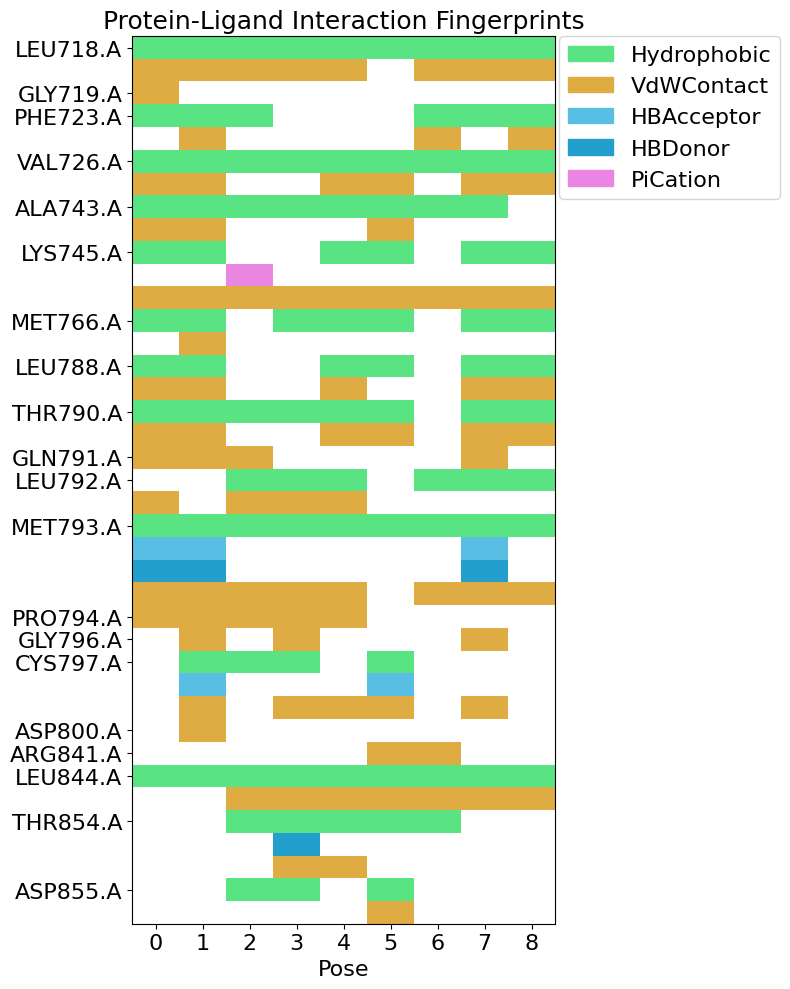

In [16]:
# Convert the fingerprint to a DataFrame for easier analysis
df_interactions = fp.to_dataframe(index_col="Pose")
print("Interaction fingerprint summary:")
print(df_interactions.head())

# Calculate Tanimoto similarity between the first pose and all other poses
from rdkit import DataStructs

bitvectors = fp.to_bitvectors()
tanimoto_sims = DataStructs.BulkTanimotoSimilarity(bitvectors[0], bitvectors)
print(f"\nTanimoto Similarities (compared to the first pose):\n{tanimoto_sims}")

# Plot interaction fingerprints as a barcode
plt.figure(figsize=(12, 8))
fp.plot_barcode(xlabel="Pose")
plt.title("Protein-Ligand Interaction Fingerprints")
plt.tight_layout()

We can take it further and visualize the interactions for the best docking pose:

In [17]:
# Plot the interaction network for the best pose (pose 0)
best_pose_index = 0
network_view = fp.plot_lignetwork(
    poses_plf[best_pose_index], 
    kind="frame", 
    frame=best_pose_index, 
    display_all=True
)

# Display the network view
network_view

Finally, let's compare the interactions between the best pose and the worst pose:

In [18]:
from prolif.plotting.complex3d import Complex3D

# Create 3D visualization for the best pose
best_pose_index = 0
best_comp3D = Complex3D.from_fingerprint(
    fp, poses_plf[best_pose_index], protein_mol, frame=best_pose_index
)

# Create 3D visualization for the worst pose
worst_pose_index = 8
worst_comp3D = Complex3D.from_fingerprint(
    fp, poses_plf[worst_pose_index], protein_mol, frame=worst_pose_index
)

# Compare the two poses
compare_view = best_comp3D.compare(worst_comp3D)

# Display the comparison view
compare_view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In the visualization above, you can see the comparison between the best binding pose (left) and the worst binding pose (right). Protein residues that have different interactions between the two poses are highlighted in magenta. This helps us understand which molecular interactions are most important for binding.

### <b> <font color='#A20025'> Docking Enamine's Hinge Binders Library

Let's see how docking scales up by repeating the same process on a small subset of compounds sampled from Enamine's library of prospective hinge binders.

First, we define a function to load molecules from either SDF or CSV file formats.

In [ ]:
def load_molecules(file_path):
    """Loads molecules from an SDF file and computes their ECFP fingerprints."""
    

    file_extension = file_path.split('.')[-1].lower()
    fingerprints = []
    valid_smiles = []
    morgan_generator = GetMorganGenerator(radius=2, fpSize=1024)
    
    if file_extension == 'sdf':
        mols = Chem.SDMolSupplier(file_path, removeHs=False)

        for mol in mols:
            if mol is not None:
                try:
                    fp = morgan_generator.GetFingerprintAsNumPy(mol)
                    fingerprints.append(fp)
                    valid_smiles.append(Chem.MolToSmiles(mol))
                except Exception as e:
                    print(f"Error processing molecule: {e}")
    elif file_extension == 'csv':
        df = pd.read_csv(file_path)
        if 'SMILES' not in df.columns:
            raise ValueError("CSV file must contain a 'SMILES' column")
        smiles_list = df['SMILES'].tolist()
        for smiles in smiles_list:
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                fp = morgan_generator.GetFingerprintAsNumPy(mol)
                fingerprints.append(fp)
                valid_smiles.append(smiles)
            else:
                print(f"Warning: Invalid SMILES string encountered: {smiles}")


    return np.array(fingerprints), valid_smiles


Next, we load in the Enamine hinge binders and dock the first 10 molecules in the library, outputing results for the top 5.

**😱 Long Running Code Block -- May Be Skipped**

Each docking run will take 1 to 2 minutes (i.e., 10-20 minutes total). **If you don't want to wait or if you lack adequate computational resources (e.g., kernel crashes), you can proceed to the next section without issue.** You will not need the results of the following 10 docking experiments for future sections. The main takeaway is that docking is computationally expensive and scaling it up, even to just 10 molecules, takes notable time (imagine if we wanted to try and dock all 24K compounds without adequate computational resources...). Hence the importance of the active learning strategy that we'll implement and showcase in section 2 of this notebook!

In [ ]:
# Load the molecule library
file_path = "data/ch09/Enamine_Hinge_Binders_Library.sdf"
X_pool, smiles_pool = load_molecules(file_path)

# Set up device and directories
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
exp_dir = "docking_enamine_hinge_binders"
input_dir = f"artifacts/ch09/{exp_dir}/inputs"
output_dir = f"artifacts/ch09/{exp_dir}/outputs"
os.makedirs(input_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

# Prepare receptor once (since it's the same for all ligands)
# The below two lines only need uncommented if receptor not already prepared
# prep = Preprocessor(fix_protein=False)
# prep.prepare_receptor(fixed_receptor_file, receptor_pdbqt)

# Load ligand to extract binding box information
original_ligand = mdtraj.load(ligand_file)
box = create_box_from_ligand(original_ligand, padding=5.0)

# Initialize docking engine with receptor and box
docker = VinaDocking(receptor_pdbqt, box, num_poses=5, exhaustiveness=8)

# Set up results tracking
docking_results = []

# Process each molecule in the library
print(f"Starting docking of {len(smiles_pool)} compounds...")
for idx, smiles in enumerate(tqdm(smiles_pool[:10])):  # Using only first 10 for example
    try:
        # Convert SMILES to RDKit molecule
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print(f"Warning: Could not parse SMILES {smiles}")
            continue
            
        # Add hydrogens and generate 3D coordinates
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol, randomSeed=42)
        AllChem.MMFFOptimizeMolecule(mol)
        
        # Dock the molecule
        affinity = docker.dock_mol(mol)
        
        # Store results
        docking_results.append({
            'smiles': smiles,
            'affinity': affinity,
            'fingerprint': X_pool[idx].tolist()
        })
        
        # Print progress for every 5 molecules
        if (idx + 1) % 5 == 0:
            print(f"Completed {idx + 1}/{len(smiles_pool[:10])} dockings")
            
    except Exception as e:
        print(f"Error processing molecule {idx} ({smiles}): {str(e)}")

# Convert results to DataFrame and sort by affinity
results_df = pd.DataFrame(docking_results)
results_df = results_df.sort_values('affinity')

# Save results
results_csv = os.path.join(output_dir, "docking_results.csv")
results_df.to_csv(results_csv, index=False)

print(f"Docking complete. Results saved to {results_csv}")
print("Top 5 compounds by binding affinity:")
print(results_df.head(5)[['smiles', 'affinity']])

Starting docking of 24000 compounds...


 20%|██        | 2/10 [00:07<00:29,  3.64s/it]

: 

## <b> <font color='#A20025'> 2️⃣ Deep Docking: Active Learning for Hit Identification

Now that we've covered the basics of molecular docking, let's explore how deep learning and active learning can make virtual screening more efficient. Deep docking is a technique that uses machine learning to predict binding affinities, allowing us to prioritize compounds for docking instead of having to dock every molecule in a large database.

### <b> <font color='#A20025'> Building a Deep Learning Surrogate Model

First, we'll implement a deep neural network that can predict binding affinities from molecular fingerprints:

In [11]:
class DeepDockingModel(nn.Module):
    """
    Neural network model for predicting molecular docking scores.
    
    This model takes molecular fingerprints as input and predicts binding affinities.
    It uses a three-layer architecture with dropout for regularization.
    """
    def __init__(self, input_size, hidden_size, output_size=1):
        """
        Initialize the model.
        
        Args:
            input_size: Dimension of the input fingerprint vector
            hidden_size: Number of neurons in the first hidden layer
            output_size: Dimension of the output (usually 1 for regression)
        """
        super(DeepDockingModel, self).__init__()
        
        # Define the neural network layers
        self.layers = nn.Sequential(
            # First hidden layer
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            # Second hidden layer (half the size of the first)
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            # Output layer
            nn.Linear(hidden_size // 2, output_size)
        )

    def forward(self, x):
        """Forward pass through the network."""
        return self.layers(x)

    def predict(self, fingerprints, device):
        """
        Predict docking scores for a batch of molecular fingerprints.
        
        Args:
            fingerprints: Array of molecular fingerprints [n_molecules, n_features]
            device: Device to run the inference on (CPU or GPU)
            
        Returns:
            Array of predicted docking scores [n_molecules]
        """
        self.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient computation for efficiency
            # Convert input to PyTorch tensor and move to device
            inputs = torch.tensor(fingerprints, dtype=torch.float32).to(device)
            # Get predictions
            outputs = self(inputs)
            # Return as numpy array
            return outputs.cpu().numpy().flatten()

We also implement a surrogate model based on Gaussian Processes, which will be used for comparing surrogate models.

In [ ]:
class GPSurrogate:
    def __init__(self, kernel=None):
        if kernel is None:
            # Default kernel: Matern kernel + White noise
            kernel = Matern(length_scale=1.0, nu=2.5) + WhiteKernel(noise_level=0.1)
        
        self.model = GaussianProcessRegressor(
            kernel=kernel,
            alpha=1e-10,  # Avoid numerical issues
            normalize_y=True,
            n_restarts_optimizer=5,
            random_state=42
        )
        self.fitted = False
    
    def fit(self, X, y):
        self.model.fit(X, y)
        self.fitted = True
    
    def predict(self, X, return_std=False):
        if not self.fitted:
            raise ValueError("Model has not been fitted yet")
        return self.model.predict(X, return_std=return_std)

We train the surrogate model using standard supervised learning techniques that we covered in chapter 8. We implement two versions. The first illustrates a minimal training function:

In [12]:
def train_deep_model(model, X_train, y_train, device, 
                     writer=None, global_step=0, epochs=10, 
                     batch_size=32, lr=0.001, **kwargs):
    """
    Simplified version of the model training function that maintains backward compatibility.
    
    Args:
        model (nn.Module): The neural network model to train
        X_train (np.ndarray): Feature matrix of shape [n_samples, n_features]
        y_train (np.ndarray): Target values of shape [n_samples]
        device (torch.device): Device to perform training on (CPU or GPU)
        writer (SummaryWriter, optional): TensorBoard writer for logging metrics
        global_step (int, optional): Current global step for TensorBoard logging
        epochs (int, optional): Number of training epochs. Defaults to 10.
        batch_size (int, optional): Training batch size. Defaults to 32.
        lr (float, optional): Learning rate for optimizer. Defaults to 0.001.
        **kwargs: Additional parameters for backward compatibility
        
    Returns:
        dict: Training history containing metrics for each epoch
    """
    # Initialize training history dictionary
    history = {"train_loss": []}
    
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Convert data to PyTorch tensors to prepare for training
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
    
    # Create DataLoader for batch processing
    train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    
    print(f"Starting training for {epochs} epochs...")
    for epoch in range(epochs):
        # Set model to training mode
        model.train()
        epoch_loss = 0.0
        num_batches = 0
        
        for inputs, labels in train_loader:
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Backward pass and update model parameters
            loss.backward()
            optimizer.step()
            
            # Accumulate batch loss
            epoch_loss += loss.item()
            num_batches += 1
        
        # Calculate average loss for the epoch
        avg_epoch_loss = epoch_loss / num_batches
        history["train_loss"].append(avg_epoch_loss)
        
        # Log metrics to TensorBoard if writer is provided
        if writer is not None:
            writer.add_scalar('Training/Loss', avg_epoch_loss, global_step*epochs + epoch)
            
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss:.4f}")
    
    print("Training completed!")
    return history

### <b> <font color='#A20025'> Active Learning Components

Now we'll implement the components needed for active learning. First, let's create functions to help with the initial sampling:

In [13]:
def initialize_samples(X_pool, initialization: str, n_samples: int) -> np.ndarray:
    """Initialize samples either randomly or using diversity picking."""
    if initialization == 'random':
        print("Selecting initial samples randomly...")
        return np.random.choice(
            len(X_pool), 
            size=n_samples, 
            replace=False
        )
    elif initialization == 'diverse':
        print("Selecting initial samples following MaxMin diversity...")
        # Use RDKit's MaxMin algorithm for diversity picking
        picker = rdSimDivPickers.MaxMinPicker()
        # Convert fingerprints to the format expected by the picker
        fps_for_diversity = [list(fp) for fp in X_pool]
        picked = list(picker.LazyBitVectorPick(
            fps_for_diversity, 
            len(fps_for_diversity),
            n_samples
        ))
        return np.array(picked)
    else:
        raise ValueError(f"Unknown initialization method: {initialization}")

Next, let's implement acquisition functions that will help us decide which molecules to select at each iteration:

In [14]:
def greedy_acquisition(model, X_pool, device, batch_size=1):
    """
    Selects the molecules with the best predicted docking scores.
    
    Parameters:
        model (DeepDockingModel): The trained surrogate model
        X_pool (np.array): Fingerprints of the pool molecules
        device (torch.device): The device to use for PyTorch computations
        batch_size (int): Number of molecules to select
        
    Returns:
        np.array: Indices of the selected molecules
    """
    # Get predictions for all molecules in the pool
    predictions = model.predict(X_pool, device)

    # Select molecules with lowest predicted binding affinities
    # (lower scores are better for binding affinity)
    best_indices = np.argsort(predictions)[:batch_size]
    return best_indices

def uncertainty_sampling(model, X_pool, device, batch_size=1, n_samples=100):
    """
    Select molecules with highest prediction uncertainty using Monte Carlo dropout.
    
    Parameters:
        model: The trained neural network model
        X_pool: Feature representations of candidate molecules
        device: Computing device (CPU/GPU)
        batch_size: Number of molecules to select
        n_samples: Number of Monte Carlo samples for uncertainty estimation
        
    Returns:
        Indices of selected molecules
    """
    # Enable dropout layers during inference
    model.train()
    
    # Initialize array to store multiple predictions
    all_predictions = np.zeros((n_samples, len(X_pool)))
    inputs = torch.tensor(X_pool, dtype=torch.float32).to(device)
    
    # Generate and store multiple predictions with dropout enabled
    for i in range(n_samples):
        with torch.no_grad():  # No need for gradients in inference
            outputs = model(inputs)
            all_predictions[i, :] = outputs.cpu().numpy().flatten()
    
    # Calculate standard deviation across samples for each molecule
    uncertainties = np.std(all_predictions, axis=0)
    
    # Select molecules with highest uncertainty
    best_indices = np.argsort(uncertainties)[::-1][:batch_size]
    
    return best_indices

def probability_of_improvement(model, X_pool, device, best_score, batch_size=1, xi=0.01, n_samples=100):
    """
    Select molecules with highest probability of improving upon the current best binding score.
    
    Parameters:
        model: The trained neural network model
        X_pool: Feature representations of candidate molecules
        device: Computing device (CPU/GPU)
        best_score: Current best binding score (lowest value for a minimization problem)
        batch_size: Number of molecules to select
        xi: Exploration parameter that encourages selecting points that might not immediately improve
        n_samples: Number of Monte Carlo samples for uncertainty estimation
        
    Returns:
        Indices of selected molecules
    """
    # Get mean predictions in evaluation mode (dropout disabled)
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(X_pool, dtype=torch.float32).to(device)
        outputs = model(inputs)
        mu = outputs.cpu().numpy().flatten()
    
    # Estimate uncertainty using Monte Carlo dropout
    model.train()  # Enable dropout
    predictions = np.zeros((n_samples, len(X_pool)))
    
    for i in range(n_samples):
        with torch.no_grad():
            outputs = model(inputs)
            predictions[i, :] = outputs.cpu().numpy().flatten()
    
    # Calculate standard deviation for each prediction
    sigma = np.std(predictions, axis=0)
    
    # Add a small epsilon to prevent division by zero
    epsilon = 1e-9
    
    # Calculate improvement - note we subtract from best_score since we're minimizing
    # xi is added to encourage exploration (larger xi means more exploration)
    improvement = best_score - (mu + xi)
    
    # Calculate the Z-score for the improvement
    Z = improvement / (sigma + epsilon)
    
    # Calculate probability using the error function (related to CDF of normal distribution)
    # This gives probability that a random sample from the predicted distribution will be better than best_score
    prob_improvement = 0.5 * (1 + np.array([math.erf(z / math.sqrt(2)) for z in Z]))
    
    # Select molecules with highest probability of improvement
    best_indices = np.argsort(prob_improvement)[::-1][:batch_size]
    
    return best_indices

def expected_improvement(model, X_pool, device, best_score, xi=0.01, n_samples=100):
    """
    Calculate expected improvement for each candidate molecule.
    
    Parameters:
        model: The trained neural network model
        X_pool: Feature representations of candidate molecules
        device: Computing device (CPU/GPU)
        best_score: Current best binding score (lowest value for minimization)
        xi: Exploration parameter, higher values favor exploration over exploitation
        n_samples: Number of Monte Carlo samples for uncertainty estimation
        
    Returns:
        Expected improvement values for each candidate molecule
    """
    # Get mean predictions
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(X_pool, dtype=torch.float32).to(device)
        outputs = model(inputs)
        mu = outputs.cpu().numpy().flatten()
    
    # Estimate uncertainty using Monte Carlo dropout
    model.train()  # Enable dropout
    predictions = np.zeros((n_samples, len(X_pool)))
    
    for i in range(n_samples):
        with torch.no_grad():
            outputs = model(inputs)
            predictions[i, :] = outputs.cpu().numpy().flatten()
    
    # Calculate standard deviation for each prediction
    sigma = np.std(predictions, axis=0)
    
    # Add a small epsilon to prevent division by zero
    epsilon = 1e-9
    
    # Calculate improvement (for minimization problems)
    improvement = best_score - (mu + xi)
    
    # Calculate Z-score
    Z = improvement / (sigma + epsilon)
    
    # Import necessary functions
    from scipy.stats import norm
    
    # Calculate expected improvement
    # First term: improvement weighted by probability of improvement
    # Second term: uncertainty weighted by Z-score's probability density
    ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
    
    # Set EI to zero where sigma is zero (no uncertainty)
    ei[sigma == 0.0] = 0.0
    
    return ei

def select_next_molecule(model, X_pool, smiles_pool, device, best_score, batch_size=1,
                         acquisition_function="greedy", xi=0.01):
    """
    Selects the next molecule to dock based on the chosen acquisition function.

    Parameters:
        model (DeepDockingModel): The trained surrogate model.
        X_pool (np.array): Fingerprints of the pool molecules.
        smiles_pool (list): SMILES strings of the pool molecules.
        device (torch.device): The device to use for PyTorch computations.
        best_score (float): The current best docking score.
        acquisition_function (str): The acquisition function to use.
        xi (float): Exploration parameter for EI and PI.

    Returns:
        int: Index of the selected molecule.
        str: SMILES string of the selected molecule.
    """
    if acquisition_function == "greedy":
        best_indices = greedy_acquisition(model, X_pool, device, batch_size)
    elif acquisition_function == "uncertainty":
        best_indices = uncertainty_sampling(model, X_pool, device)
    elif acquisition_function == "pi":
        best_indices = probability_of_improvement(model, X_pool, device, best_score, xi)
    elif acquisition_function == "ei":
        best_indices = expected_improvement(model, X_pool, device, best_score, xi)
    else:
        raise ValueError(f"Unknown acquisition function: {acquisition_function}")

    best_smiles = [smiles_pool[i] for i in best_indices]
    return best_indices, best_smiles

The Oracle

In [15]:
def vina_oracle(smiles_list, box, receptor_file, num_poses=5, **kwargs):
    """
    Performs molecular docking using Vina to get binding scores.

    Parameters:
        smiles_list (list): A list of SMILES strings representing the molecules.
        box (tuple): The search box coordinates (center_x, center_y, center_z, size_x, size_y, size_z).
        receptor_file (str): Path to the prepared receptor file (PDBQT format).
        num_poses (int): Number of poses to generate for each molecule.

    Returns:
        list: A list of docking scores (best score for each molecule).
    """
    params = Chem.SmilesParserParams()
    params.removeHs = False

    scores = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles, params)
        mol = Chem.AddHs(mol)

        has_3d = False
        try: has_3d = mol.GetConformer().Is3D()
        except: has_3d = False
        if not has_3d:
            AllChem.EmbedMolecule(mol, randomSeed=42)
            AllChem.MMFFOptimizeMolecule(mol)
        docking_program = VinaDocking(receptor_file, box, num_poses=num_poses)
        score = docking_program.dock_mol(mol)
        scores.append(score)
    return scores

def deepdock_oracle(smiles_list, **kwargs):
    reference_df = kwargs['reference_df']
    return reference_df["r_i_docking_score"].values[kwargs['idx_list']]

### <b> <font color='#A20025'> Setting Up Tensorboard for Visualization

During training, notice the incorporation of a TensorBoard writer for logging metrics and tracking the progress of our active learning loop. Let's set up the necessary functions to support this:

In [16]:
def initialize_tensorboard(log_dir):
    """
    Initialize TensorBoard for logging experiment metrics.
    
    Args:
        log_dir: Directory for TensorBoard logs
        
    Returns:
        TensorBoard SummaryWriter
    """
    import shutil
    
    # Clear existing directory if it exists
    if os.path.exists(log_dir):
        try:
            shutil.rmtree(log_dir)
        except Exception as e:
            print(f"Error while deleting directory '{log_dir}': {e}")
    
    # Create new SummaryWriter
    writer = SummaryWriter(log_dir=log_dir)
    print(f"TensorBoard initialized. View logs with: tensorboard --logdir={log_dir}")
    return writer

We'll also implement a helper function to plot our coverage of chemical space with each active learning iteration:

In [17]:
def plot_chemical_space(writer, X_pool, X_sampled, step, label="chemical_space"):
    """
    Create PCA visualization of chemical space coverage.
    
    Args:
        writer: TensorBoard SummaryWriter
        X_pool: Features of remaining molecules in the pool
        X_sampled: Features of molecules that have been sampled
        step: Current iteration step
        label: Label for the plot
    """
    from sklearn.decomposition import PCA
    
    # Combine pool and sampled data
    X_combined = np.vstack([X_pool, X_sampled])
    
    # Create labels (0 for pool, 1 for sampled)
    labels = np.zeros(len(X_combined))
    labels[len(X_pool):] = 1
    
    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_combined)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot pool molecules
    pool_mask = labels == 0
    ax.scatter(X_pca[pool_mask, 0], X_pca[pool_mask, 1],
              c='lightgray', alpha=0.5, s=20, label='Pool molecules')
    
    # Plot sampled molecules
    sampled_mask = labels == 1
    ax.scatter(X_pca[sampled_mask, 0], X_pca[sampled_mask, 1],
              c='blue', alpha=0.7, s=30, label='Sampled molecules')
    
    ax.set_title(f'Chemical Space Coverage (Step {step})')
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    ax.legend()
    
    # Log to TensorBoard
    writer.add_figure(label, fig, global_step=step)
    plt.close(fig)  # Close the figure to free memory

### <b> <font color='#A20025'> Implementing the Active Learning Loop

We put everything together to implement the complete active learning loop for deep docking:

In [ ]:
def calculate_top_molecules_captured(selected_smiles, top_100_smiles):
    """Calculate how many of the top 100 molecules have been found."""
    return len(set(selected_smiles).intersection(top_100_smiles))

def active_learning_loop(X_pool, smiles_pool, n_initial_samples,
                         n_iterations, budget_per_iteration, device,
                         reference_df=None, receptor_file=None, top_reference_smiles=[],
                         initial_selection_method="random", oracle=deepdock_oracle,
                         box=None, acquisition_function="greedy", xi=0.01,
                         log_dir="tensorboard_logs"):
    """
    Implements the active learning loop for deep docking.

    Parameters:
        X_pool (np.array): Fingerprints of all molecules in the pool.
        smiles_pool (list): SMILES strings of all molecules in the pool.
        n_initial_samples (int): Number of initial samples to dock.
        n_iterations (int): Number of active learning iterations.
        budget_per_iteration (int): Total budget for docking calls.
        device (torch.device): The device to use for PyTorch computations (CPU or GPU).
        reference_df (pd.DataFrame): DataFrame containing reference docking scores for proxy oracle.
        receptor_file (str): Path to the prepared receptor file (PDBQT format).
        top_reference_smiles (list): List of top reference SMILES for evaluation.
        initial_selection_method (str): Method for selecting initial samples ('random' or 'diverse').
        oracle (function): Oracle function for docking.
        box (tuple): The search box coordinates (center_x, center_y, center_z, size_x, size_y, size_z).
        acquisition_function (str): The acquisition function to use.
        xi (float): Exploration parameter for EI and PI.
        log_dir (str): Directory for TensorBoard logs.

    Returns:
        pd.DataFrame: Results of the active learning loop.
    """
    # Set up device
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Set up TensorBoard
    writer = initialize_tensorboard(log_dir)

    # Select initial samples
    print(f"Step 1: Selecting {n_initial_samples} initial samples via {initial_selection_method}...")
    initial_indices = initialize_samples(X_pool, initial_selection_method, n_initial_samples)
    X_train = X_pool[initial_indices]
    smiles_train = [smiles_pool[i] for i in initial_indices]

    # Perform docking for initial samples
    print("Step 2: Docking initial samples...")
    y_train = oracle(smiles_train, box=box, idx_list=initial_indices, reference_df=reference_df, receptor_file=receptor_file)

    # Update tracking variables
    best_score = min(y_train)

    # Track initial performance
    top_molecules_found = calculate_top_molecules_captured(smiles_train, top_reference_smiles)
    writer.add_scalar('Performance/TopMoleculesFound', top_molecules_found, 0)
    writer.add_scalar('Performance/BestScore', best_score, 0)
    print(f"Selected {len(X_train)} initial samples. Found {top_molecules_found} top molecules.")

    # Remove initial samples from the pool
    mask = np.ones(len(X_pool), dtype=bool)
    mask[initial_indices] = False
    X_pool = X_pool[mask]
    smiles_pool = [s for i, s in enumerate(smiles_pool) if mask[i]]

    # Initialize and train the surrogate model
    print("Step 3: Training initial surrogate model...")
    model = DeepDockingModel(input_size=X_train.shape[1], hidden_size=512, output_size=1).to(device)
    train_history = train_deep_model(model, X_train, y_train, device, writer, global_step=0, epochs=10, batch_size=32)

    print(f"Step 4: Starting active learning loop for {n_iterations} iterations...")
    results = []
    for iteration in range(n_iterations):
        print(f"\nStarting iteration {iteration + 1}/{n_iterations}")
        
        # Select batch of molecules
        print(f"Selecting {budget_per_iteration} molecules using {acquisition_function} acquisition...")
        start_time = time.time()
        best_indices, best_smiles = select_next_molecule(
            model, X_pool, smiles_pool, device, best_score, 
            batch_size=budget_per_iteration, 
            acquisition_function=acquisition_function, xi=xi, 
        )
        iteration_time = time.time() - start_time

        # Dock the selected molecules
        print("Docking selected molecules...")
        true_scores = oracle(best_smiles, box=box, idx_list=best_indices, reference_df=reference_df, receptor_file=receptor_file)
        best_score = min(best_score, min(true_scores))

        # Store selected molecules and scores
        selected_smiles_iter = best_smiles
        selected_scores_iter = true_scores

        # Update pool (remove selected molecules)
        mask = np.ones(len(X_pool), dtype=bool)
        mask[best_indices] = False
        X_pool = X_pool[mask]
        smiles_pool = [s for i, s in enumerate(smiles_pool) if mask[i]]

        X_new = X_pool[best_indices]
        smiles_train.extend(selected_smiles_iter)
        y_train = np.concatenate([y_train, selected_scores_iter])
        X_train = np.vstack([X_train, X_new])

        # Calculate and log metrics
        top_molecules_found = calculate_top_molecules_captured(smiles_train, top_reference_smiles)
        writer.add_scalar('Performance/TopMoleculesFound', top_molecules_found, iteration)
        writer.add_scalar('Performance/BestScore', best_score, iteration)
        print(f"Selected {len(smiles_train)} initial samples. Found {top_molecules_found} top molecules.")

        # Store results for this iteration
        results.append({
            'iteration': iteration + 1,
            'total_molecules': len(smiles_train),
            'top_molecules_found': top_molecules_found,
            'best_score': best_score,
            'time_per_iteration': iteration_time
        })

        # Retrain the model with all sampled data
        print("Retraining surrogate model...")
        train_deep_model(model, X_train, y_train, device, writer, iteration + 1)

        # Add chemical space visualization
        plot_chemical_space(writer, X_pool, X_train, iteration + 1)

        # Check if we've exhausted the pool
        if len(smiles_pool) == 0:
            print("Molecule pool is empty. Terminating the active learning loop.")
            break

    writer.close()
    return pd.DataFrame(results)

Below, we run our active learning experiment for hit identification.

In [21]:
csv_path = "data/ch09/4AG8_docking.csv"
df = pd.read_csv(csv_path)
top_100_df = df.nsmallest(100, 'r_i_docking_score')
top_100_smiles = set(top_100_df['SMILES'])
X_pool, smiles_pool = load_molecules(csv_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

exp_dir = "4AG8_docking_experiment"
input_dir = f"artifacts/ch09/{exp_dir}/inputs"
output_dir = f"artifacts/ch09/{exp_dir}/outputs"
os.makedirs(input_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

results_df = active_learning_loop(
    X_pool=X_pool, smiles_pool=smiles_pool,
    n_initial_samples=5000, n_iterations=10, budget_per_iteration=250,
    device=device, initial_selection_method="random",
    reference_df=df, top_reference_smiles=top_100_smiles,
    oracle=deepdock_oracle, box=None, acquisition_function="greedy",
    log_dir=f"artifacts/{CHAPTER}/{exp_dir}/tensorboard_logs",
   )
results_df.to_csv("artifacts/ch09/active_learning_results_2.csv", index=False)
print("Active learning completed. Results saved to active_learning_results.csv")

Using device: cpu
TensorBoard initialized. View logs with: tensorboard --logdir=artifacts/ch09/4AG8_docking_experiment/tensorboard_logs
Step 1: Selecting 5000 initial samples via random...
Selecting initial samples randomly...
Step 2: Docking initial samples...
Selected 5000 initial samples. Found 4 top molecules.
Step 3: Training initial surrogate model...
Starting training for 10 epochs...
Epoch 1/10, Loss: 24.7968
Epoch 2/10, Loss: 11.4426
Epoch 3/10, Loss: 10.0905
Epoch 4/10, Loss: 8.9326
Epoch 5/10, Loss: 7.5483
Epoch 6/10, Loss: 6.5056
Epoch 7/10, Loss: 5.8360
Epoch 8/10, Loss: 5.2236
Epoch 9/10, Loss: 4.7364
Epoch 10/10, Loss: 4.5458
Training completed!
Step 4: Starting active learning loop for 10 iterations...

Starting iteration 1/10
Selecting 250 molecules using greedy acquisition...
Docking selected molecules...
Selected 5250 initial samples. Found 18 top molecules.
Retraining surrogate model...
Starting training for 10 epochs...
Epoch 1/10, Loss: 5.1975
Epoch 2/10, Loss: 5.

In [29]:
print(results_df.head(10).to_string())

   iteration  total_molecules  top_molecules_found  best_score  time_per_iteration
0          1             5250                   18  -20.596266            2.977570
1          2             5500                   30  -20.596266            3.085583
2          3             5750                   45  -20.596266            2.594170
3          4             6000                   60  -20.660721            2.739418
4          5             6250                   77  -20.660721            2.607599
5          6             6500                   87  -20.660721            2.779646
6          7             6750                   94  -20.660721            2.533440
7          8             7000                   99  -20.660721            2.558523
8          9             7250                  100  -20.660721            2.524760
9         10             7500                  100  -20.660721            2.685752


While the active learning pipeline is running, or after it has completed, we can also launch TensorBoard with our log directory as an argument, allowing us to examine metrics or visualizations that quantify how well the pipeline is progressing. Consult instructions in chapter 9 on how to do this through either Visual Studio Code (as an IDE-based example) or Colab.

Active learning is a complex methodology whose effectiveness depends on several interrelated factors, including initial sample selection, acquisition functions, and batch sizes. To understand the role of each factor, we can conduct ablation studies, where we remove or modify individual components and measure their effect on the output as a reflection of their specific contribution to the overall performance. To properly evaluate different configurations and understand their relative performance, systematic experimentation is essential but can quickly become unwieldy without proper organization.

We implement an ExperimentManage class as a reference for managing active learning experiments. 

In [30]:
class ExperimentManager:
    """
    Manages experiments for comparing different active learning configurations.
    """
    def __init__(self, base_dir="experiments", X_pool=None, smiles_pool=None, 
                 top_reference_smiles=None, device=None, oracle=None, reference_df=None):
        """
        Initialize the experiment manager.
        
        Args:
            base_dir (str): Base directory for storing experiment results
            X_pool (np.ndarray): Molecular fingerprints for the pool
            smiles_pool (list): SMILES strings for the pool molecules
            top_reference_smiles (list): Reference set of top molecule SMILES
            device (torch.device): Device for running computations
            oracle (callable): Function to evaluate molecules
        """
        self.base_dir = base_dir
        self.X_pool = X_pool
        self.smiles_pool = smiles_pool
        self.top_reference_smiles = top_reference_smiles
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.oracle = oracle
        self.df = reference_df
        
        # Create base directory if it doesn't exist
        os.makedirs(self.base_dir, exist_ok=True)
        
    def _generate_experiment_id(self, config):
        """
        Generate a unique, descriptive ID for an experiment based on its configuration.
        
        Args:
            config (dict): Experiment configuration
            
        Returns:
            str: Unique experiment ID
        """
        # Extract key parameters for the ID
        init_samples = config.get('n_initial_samples', 'x')
        init_method = config.get('initial_selection_method', 'random')[:3]
        acq_function = config.get('acquisition_function', 'greedy')[:3]
        budget = config.get('budget_per_iteration', 'x')
        iterations = config.get('n_iterations', 'x')
        
        # Create a timestamp to ensure uniqueness
        timestamp = datetime.datetime.now().strftime("%m%d_%H%M")
        
        # Combine parameters into a descriptive ID
        exp_id = f"init{init_samples}_{init_method}_acq{acq_function}_bud{budget}_iter{iterations}_{timestamp}"
        
        return exp_id
    
    def run_experiment(self, config, exp_id=None):
        """
        Run a single experiment with the given configuration.
        
        Args:
            config (dict): Experiment configuration
            exp_id (str, optional): Experiment ID. If None, one will be generated.
            
        Returns:
            tuple: (experiment_id, results_df)
        """
        # Generate experiment ID if not provided
        if exp_id is None:
            exp_id = self._generate_experiment_id(config)
            
        # Create experiment directory
        exp_dir = os.path.join(self.base_dir, exp_id)
        os.makedirs(exp_dir, exist_ok=True)
        
        # Save configuration
        config_path = os.path.join(exp_dir, "config.json")
        with open(config_path, 'w') as f:
            json.dump(config, f, indent=4)
            
        # Set up logging directory
        log_dir = os.path.join(exp_dir, "tensorboard_logs")
        
        print(f"Running experiment: {exp_id}")
        start_time = time.time()
        
        # Run the active learning loop with this configuration
        results_df = active_learning_loop(
            X_pool=self.X_pool.copy(),
            smiles_pool=self.smiles_pool.copy(),
            n_initial_samples=config.get('n_initial_samples', 100),
            n_iterations=config.get('n_iterations', 10),
            budget_per_iteration=config.get('budget_per_iteration', 10),
            device=self.device,
            top_reference_smiles=self.top_reference_smiles,
            initial_selection_method=config.get('initial_selection_method', 'random'),
            reference_df=self.df,
            oracle=self.oracle,
            box=config.get('box', None),
            acquisition_function=config.get('acquisition_function', 'greedy'),
            xi=config.get('xi', 0.01),
            log_dir=log_dir
        )

        # Add experiment metadata to results
        results_df['experiment_id'] = exp_id
        for key, value in config.items():
            results_df[key] = value
            
        # Calculate total runtime
        total_time = time.time() - start_time
        results_df['total_runtime'] = total_time
        
        # Save results
        results_path = os.path.join(exp_dir, "results.csv")
        results_df.to_csv(results_path, index=False)
        
        print(f"Experiment {exp_id} completed in {total_time:.2f} seconds")
        
        return exp_id, results_df
        
    def run_comparison(self, configs, parallel=False, max_workers=None):
        """
        Run multiple experiments with different configurations for comparison.
        
        Args:
            configs (list): List of configuration dictionaries
            parallel (bool): Whether to run experiments in parallel
            max_workers (int, optional): Maximum number of parallel workers
            
        Returns:
            dict: Dictionary mapping experiment IDs to results DataFrames
        """
        results = {}
        
        if parallel and len(configs) > 1:
            print(f"Running {len(configs)} experiments in parallel")
            with ProcessPoolExecutor(max_workers=max_workers) as executor:
                # Submit all experiments to the executor
                future_to_config = {
                    executor.submit(self.run_experiment, config): i 
                    for i, config in enumerate(configs)
                }
                
                # Process results as they complete
                for future in tqdm(as_completed(future_to_config), total=len(configs)):
                    i = future_to_config[future]
                    try:
                        exp_id, results_df = future.result()
                        results[exp_id] = results_df
                        print(f"Completed experiment {i+1}/{len(configs)}: {exp_id}")
                    except Exception as e:
                        print(f"Experiment {i} failed with error: {e}")
        else:
            print(f"Running {len(configs)} experiments sequentially")
            for i, config in enumerate(configs):
                try:
                    print(f"Starting experiment {i+1}/{len(configs)}")
                    exp_id, results_df = self.run_experiment(config)
                    results[exp_id] = results_df
                except Exception as e:
                    print(f"Experiment {i+1} failed with error: {e}")
        
        # Save the combined results
        self._save_combined_results(results)
        
        return results
    
    def _save_combined_results(self, results):
        """
        Save combined results from multiple experiments.
        
        Args:
            results (dict): Dictionary mapping experiment IDs to results DataFrames
        """
        combined_df = pd.concat(results.values(), ignore_index=True)
        combined_path = os.path.join(self.base_dir, "combined_results.csv")
        combined_df.to_csv(combined_path, index=False)
        
    def load_experiments(self, exp_ids=None):
        """
        Load results from previously run experiments.
        
        Args:
            exp_ids (list, optional): List of experiment IDs to load. If None, all experiments in the base directory will be loaded.
            
        Returns:
            dict: Dictionary mapping experiment IDs to results DataFrames
        """
        results = {}
        
        # If no experiment IDs are provided, find all experiment directories
        if exp_ids is None:
            exp_ids = [d for d in os.listdir(self.base_dir) 
                      if os.path.isdir(os.path.join(self.base_dir, d)) and not d.startswith('.')]
        
        for exp_id in exp_ids:
            results_path = os.path.join(self.base_dir, exp_id, "results.csv")
            if os.path.exists(results_path):
                results_df = pd.read_csv(results_path)
                results[exp_id] = results_df
                
        return results
    
    def plot_results(self, results, metrics=None, save_dir=None, show=True):
        """
        Generate comparison plots for the experiment results.
        
        Args:
            results (dict): Dictionary mapping experiment IDs to results DataFrames
            metrics (list, optional): Metrics to plot. If None, default metrics will be used.
            save_dir (str, optional): Directory to save plots. If None, plots will be saved in the base directory.
            show (bool): Whether to display the plots
            
        Returns:
            dict: Dictionary of plot objects
        """
        # Default metrics to plot
        if metrics is None:
            metrics = ['top_molecules_found', 'best_score', 'time_per_iteration']
            
        # Determine save directory
        if save_dir is None:
            save_dir = os.path.join(self.base_dir, "plots")
        os.makedirs(save_dir, exist_ok=True)
        
        plots = {}
        
        # Set up the plot style
        sns.set_style("whitegrid")
        plt.rcParams.update({'font.size': 12})
        
        # 1. Top molecules found vs. iterations
        if 'top_molecules_found' in metrics:
            fig, ax = plt.subplots(figsize=(12, 8))
            for exp_id, df in results.items():
                # Extract configuration details for the legend
                config_path = os.path.join(self.base_dir, exp_id, "config.json")
                if os.path.exists(config_path):
                    with open(config_path, 'r') as f:
                        config = json.load(f)
                    label = f"{config.get('initial_selection_method', 'random')}_{config.get('acquisition_function', 'greedy')}_init{config.get('n_initial_samples', 'x')}"
                else:
                    label = exp_id
                
                ax.plot(df['iteration'], df['top_molecules_found'], marker='o', linewidth=2, label=label)
                
            ax.set_xlabel('Iteration')
            ax.set_ylabel('Top Molecules Found')
            ax.set_title('Top Molecules Found vs. Iterations')
            ax.legend(loc='best')
            ax.grid(True)
            
            # Save the plot
            plot_path = os.path.join(save_dir, "top_molecules_vs_iterations.png")
            plt.savefig(plot_path, dpi=300, bbox_inches='tight')
            
            plots['top_molecules_found'] = fig
            
        # 2. Best score vs. iterations
        if 'best_score' in metrics:
            fig, ax = plt.subplots(figsize=(12, 8))
            for exp_id, df in results.items():
                # Extract configuration details for the legend
                config_path = os.path.join(self.base_dir, exp_id, "config.json")
                if os.path.exists(config_path):
                    with open(config_path, 'r') as f:
                        config = json.load(f)
                    label = f"{config.get('initial_selection_method', 'random')}_{config.get('acquisition_function', 'greedy')}_init{config.get('n_initial_samples', 'x')}"
                else:
                    label = exp_id
                
                ax.plot(df['iteration'], df['best_score'], marker='o', linewidth=2, label=label)
                
            ax.set_xlabel('Iteration')
            ax.set_ylabel('Best Score')
            ax.set_title('Best Score vs. Iterations')
            ax.legend(loc='best')
            ax.grid(True)
            
            # Save the plot
            plot_path = os.path.join(save_dir, "best_score_vs_iterations.png")
            plt.savefig(plot_path, dpi=300, bbox_inches='tight')
            
            plots['best_score'] = fig
            
        # 3. Time per iteration
        if 'time_per_iteration' in metrics:
            fig, ax = plt.subplots(figsize=(12, 8))
            for exp_id, df in results.items():
                # Extract configuration details for the legend
                config_path = os.path.join(self.base_dir, exp_id, "config.json")
                if os.path.exists(config_path):
                    with open(config_path, 'r') as f:
                        config = json.load(f)
                    label = f"{config.get('initial_selection_method', 'random')}_{config.get('acquisition_function', 'greedy')}_init{config.get('n_initial_samples', 'x')}"
                else:
                    label = exp_id
                
                ax.plot(df['iteration'], df['time_per_iteration'], marker='o', linewidth=2, label=label)
                
            ax.set_xlabel('Iteration')
            ax.set_ylabel('Time (seconds)')
            ax.set_title('Time per Iteration')
            ax.legend(loc='best')
            ax.grid(True)
            
            # Save the plot
            plot_path = os.path.join(save_dir, "time_per_iteration.png")
            plt.savefig(plot_path, dpi=300, bbox_inches='tight')
            
            plots['time_per_iteration'] = fig
            
        # 4. Efficiency plot (top molecules found per total budget)
        fig, ax = plt.subplots(figsize=(12, 8))
        for exp_id, df in results.items():
            # Extract configuration details for the legend
            config_path = os.path.join(self.base_dir, exp_id, "config.json")
            if os.path.exists(config_path):
                with open(config_path, 'r') as f:
                    config = json.load(f)
                
                n_initial = config.get('n_initial_samples', 0)
                budget_per_iter = config.get('budget_per_iteration', 0)
                
                # Calculate total budget used at each iteration
                df['total_budget'] = n_initial + df['iteration'] * budget_per_iter
                
                label = f"{config.get('initial_selection_method', 'random')}_{config.get('acquisition_function', 'greedy')}_init{n_initial}"
            else:
                label = exp_id
                df['total_budget'] = df['total_molecules']  # Fallback if config not available
            
            ax.plot(df['total_budget'], df['top_molecules_found'], marker='o', linewidth=2, label=label)
            
        ax.set_xlabel('Total Budget Used')
        ax.set_ylabel('Top Molecules Found')
        ax.set_title('Efficiency: Top Molecules Found vs. Total Budget')
        ax.legend(loc='best')
        ax.grid(True)
        
        # Save the plot
        plot_path = os.path.join(save_dir, "efficiency_plot.png")
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        
        plots['efficiency'] = fig
        
        # 5. Heatmap for parameter comparison
        # This requires extracting final metrics for each experiment
        data = []
        for exp_id, df in results.items():
            config_path = os.path.join(self.base_dir, exp_id, "config.json")
            if os.path.exists(config_path):
                with open(config_path, 'r') as f:
                    config = json.load(f)
                
                # Get final values
                final_row = df.iloc[-1]
                
                # Extract key parameters and metrics
                data.append({
                    'exp_id': exp_id,
                    'n_initial_samples': config.get('n_initial_samples', 'N/A'),
                    'initial_selection_method': config.get('initial_selection_method', 'N/A'),
                    'acquisition_function': config.get('acquisition_function', 'N/A'),
                    'budget_per_iteration': config.get('budget_per_iteration', 'N/A'),
                    'n_iterations': config.get('n_iterations', 'N/A'),
                    'final_top_molecules': final_row.get('top_molecules_found', 0),
                    'final_best_score': final_row.get('best_score', 0),
                    'total_runtime': final_row.get('total_runtime', 0)
                })
        
        if data:
            # Convert to DataFrame for easier plotting
            params_df = pd.DataFrame(data)
            
            # Create a pivot table for the heatmap - Acquisition function vs Initial selection method
            # Using top molecules found as the value
            if len(params_df['acquisition_function'].unique()) > 1 and len(params_df['initial_selection_method'].unique()) > 1:
                pivot_table = params_df.pivot_table(
                    index='acquisition_function', 
                    columns='initial_selection_method',
                    values='final_top_molecules',
                    aggfunc='mean'
                )
                
                fig, ax = plt.subplots(figsize=(10, 8))
                sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", ax=ax)
                ax.set_title('Top Molecules Found by Strategy Combination')
                
                # Save the plot
                plot_path = os.path.join(save_dir, "strategy_heatmap.png")
                plt.savefig(plot_path, dpi=300, bbox_inches='tight')
                
                plots['strategy_heatmap'] = fig
        
        if not show:
            plt.close('all')
            
        return plots
    
    def create_summary_table(self, results, metrics=None, save_path=None):
        """
        Create a summary table of the experiment results.
        
        Args:
            results (dict): Dictionary mapping experiment IDs to results DataFrames
            metrics (list, optional): Metrics to include in the summary. If None, default metrics will be used.
            save_path (str, optional): Path to save the summary table. If None, table will be saved in the base directory.
            
        Returns:
            pd.DataFrame: Summary table
        """
        # Default metrics to include
        if metrics is None:
            metrics = ['top_molecules_found', 'best_score', 'time_per_iteration', 'total_runtime']
            
        # Determine save path
        if save_path is None:
            save_path = os.path.join(self.base_dir, "summary_table.csv")
            
        # Extract summary data
        summary_data = []
        
        for exp_id, df in results.items():
            # Get the last row of the results (final state)
            final_state = df.iloc[-1].to_dict()
            
            # Extract configuration
            config_path = os.path.join(self.base_dir, exp_id, "config.json")
            config = {}
            if os.path.exists(config_path):
                with open(config_path, 'r') as f:
                    config = json.load(f)
            
            # Create a row for the summary table
            row = {
                'experiment_id': exp_id,
                'n_initial_samples': config.get('n_initial_samples', 'N/A'),
                'initial_selection_method': config.get('initial_selection_method', 'N/A'),
                'acquisition_function': config.get('acquisition_function', 'N/A'),
                'budget_per_iteration': config.get('budget_per_iteration', 'N/A'),
                'n_iterations': config.get('n_iterations', 'N/A'),
            }
            
            # Add the requested metrics
            for metric in metrics:
                if metric in final_state:
                    row[f'final_{metric}'] = final_state[metric]
                    
                    # For some metrics, calculate efficiency (per budget unit)
                    if metric in ['top_molecules_found', 'best_score']:
                        total_budget = config.get('n_initial_samples', 0) + \
                                      config.get('n_iterations', 0) * config.get('budget_per_iteration', 0)
                        if total_budget > 0:
                            if metric == 'top_molecules_found':
                                row[f'{metric}_efficiency'] = final_state[metric] / total_budget
                            elif metric == 'best_score':
                                # Lower scores are better for docking, so use negative value for efficiency
                                row[f'{metric}_efficiency'] = -1 * final_state[metric] / total_budget
            
            summary_data.append(row)
            
        # Create the summary DataFrame
        summary_df = pd.DataFrame(summary_data)
        
        # Save the summary table
        if save_path:
            summary_df.to_csv(save_path, index=False)
            
            # Also save as LaTeX table for easy inclusion in papers
            latex_path = save_path.replace('.csv', '.tex')
            try:
                latex_table = summary_df.to_latex(index=False)
                with open(latex_path, 'w') as f:
                    f.write(latex_table)
            except:
                print("Could not generate LaTeX table - pandas to_latex conversion failed")
        
        return summary_df


# Example usage
def create_experiment_configs(param_grid):
    """
    Create a list of experiment configurations from a parameter grid.
    
    Args:
        param_grid (dict): Dictionary mapping parameter names to lists of values
        
    Returns:
        list: List of configuration dictionaries
    """
    import itertools
    
    # Get all parameter names and values
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    
    # Generate all combinations of parameters
    configs = []
    for combination in itertools.product(*param_values):
        config = {name: value for name, value in zip(param_names, combination)}
        configs.append(config)
        
    return configs

Example usage shown below
This would generate 3×2×3×2×4 = 144 different experiment configurations

In [31]:
# Example parameter grid
example_param_grid = {
    'n_initial_samples': [100, 500, 1000],
    'n_iterations': [5, 10],
    'budget_per_iteration': [10, 20, 50],
    'initial_selection_method': ['random', 'diverse'],
    'acquisition_function': ['greedy', 'ei', 'pi', 'uncertainty']
}
example_configs = create_experiment_configs(example_param_grid)
print(example_configs)

#Then to run the experiments:
# manager = ExperimentManager(X_pool=X_pool, smiles_pool=smiles_pool, 
#                            top_reference_smiles=top_100_smiles,
#                            oracle=deepdock_oracle, reference_df=df)
# results = manager.run_comparison(example_configs)
# manager.plot_results(results)
# summary = manager.create_summary_table(results)

[{'n_initial_samples': 100, 'n_iterations': 5, 'budget_per_iteration': 10, 'initial_selection_method': 'random', 'acquisition_function': 'greedy'}, {'n_initial_samples': 100, 'n_iterations': 5, 'budget_per_iteration': 10, 'initial_selection_method': 'random', 'acquisition_function': 'ei'}, {'n_initial_samples': 100, 'n_iterations': 5, 'budget_per_iteration': 10, 'initial_selection_method': 'random', 'acquisition_function': 'pi'}, {'n_initial_samples': 100, 'n_iterations': 5, 'budget_per_iteration': 10, 'initial_selection_method': 'random', 'acquisition_function': 'uncertainty'}, {'n_initial_samples': 100, 'n_iterations': 5, 'budget_per_iteration': 10, 'initial_selection_method': 'diverse', 'acquisition_function': 'greedy'}, {'n_initial_samples': 100, 'n_iterations': 5, 'budget_per_iteration': 10, 'initial_selection_method': 'diverse', 'acquisition_function': 'ei'}, {'n_initial_samples': 100, 'n_iterations': 5, 'budget_per_iteration': 10, 'initial_selection_method': 'diverse', 'acquisit

Do some setup

In [32]:
# Set up experiment parameters
BASE_DIR = "artifacts/ch09/al_experiments"
CSV_PATH = "data/ch09/4AG8_docking.csv"

Run the script to execute all experiment configurations

Loading molecules from CSV...
Loaded 50000 molecules
Using device: cpu
Created 36 experiment configurations
Starting experiments...
Running 36 experiments sequentially
Starting experiment 1/36
Running experiment: init100_ran_acqgre_bud20_iter20_0323_1642
Using device: cpu
TensorBoard initialized. View logs with: tensorboard --logdir=artifacts/ch09/al_experiments/init100_ran_acqgre_bud20_iter20_0323_1642/tensorboard_logs
Step 1: Selecting 100 initial samples via random...
Selecting initial samples randomly...
Step 2: Docking initial samples...
Selected 100 initial samples. Found 0 top molecules.
Step 3: Training initial surrogate model...
Starting training for 10 epochs...
Epoch 1/10, Loss: 162.6452
Epoch 2/10, Loss: 139.8982
Epoch 3/10, Loss: 89.3629
Epoch 4/10, Loss: 30.1087
Epoch 5/10, Loss: 33.0492
Epoch 6/10, Loss: 25.7161
Epoch 7/10, Loss: 17.5683
Epoch 8/10, Loss: 12.3724
Epoch 9/10, Loss: 17.9398
Epoch 10/10, Loss: 14.5607
Training completed!
Step 4: Starting active learning loo

/home/nflynn/anaconda3/envs/ml4dd2025/lib/python3.12/site-packages/torch/utils/tensorboard/_utils.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  canvas.draw()



Starting iteration 14/20
Selecting 20 molecules using greedy acquisition...
Docking selected molecules...
Selected 1280 initial samples. Found 15 top molecules.
Retraining surrogate model...
Starting training for 10 epochs...
Epoch 1/10, Loss: 2.7951
Epoch 2/10, Loss: 2.4972
Epoch 3/10, Loss: 2.4374
Epoch 4/10, Loss: 3.0531
Epoch 5/10, Loss: 2.5740
Epoch 6/10, Loss: 2.3798
Epoch 7/10, Loss: 2.3194
Epoch 8/10, Loss: 2.2110
Epoch 9/10, Loss: 2.3634
Epoch 10/10, Loss: 2.4857
Training completed!

Starting iteration 15/20
Selecting 20 molecules using greedy acquisition...
Docking selected molecules...
Selected 1300 initial samples. Found 15 top molecules.
Retraining surrogate model...
Starting training for 10 epochs...
Epoch 1/10, Loss: 2.7431
Epoch 2/10, Loss: 2.6680
Epoch 3/10, Loss: 2.4498
Epoch 4/10, Loss: 2.3606
Epoch 5/10, Loss: 2.3795
Epoch 6/10, Loss: 2.3553
Epoch 7/10, Loss: 2.3468
Epoch 8/10, Loss: 2.4181
Epoch 9/10, Loss: 2.4304
Epoch 10/10, Loss: 2.2644
Training completed!

Sta

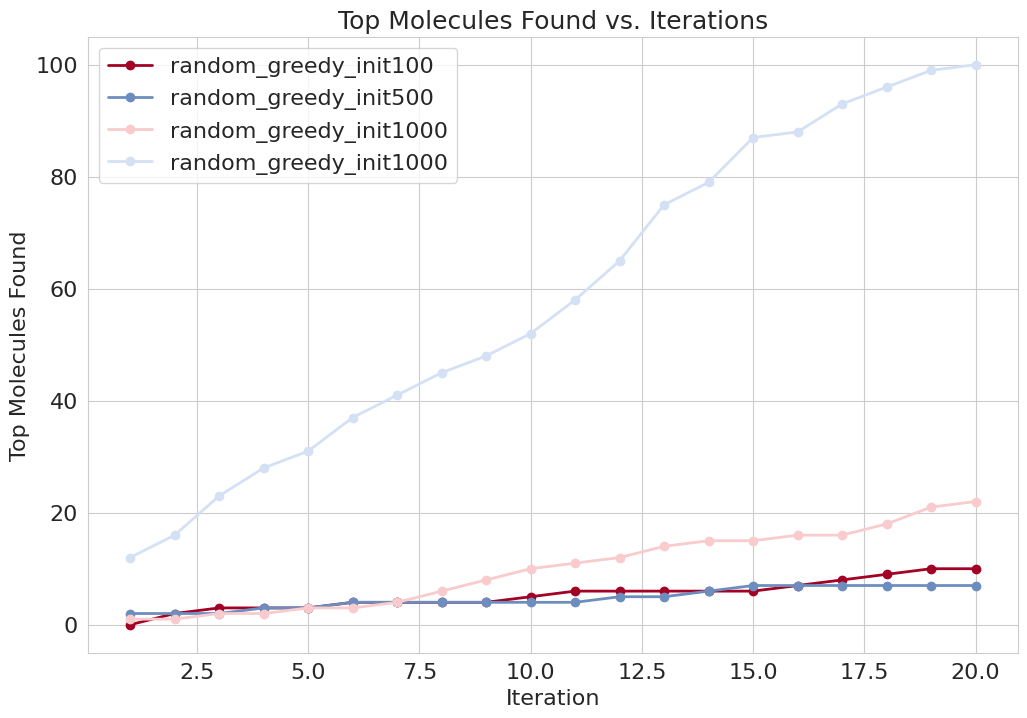

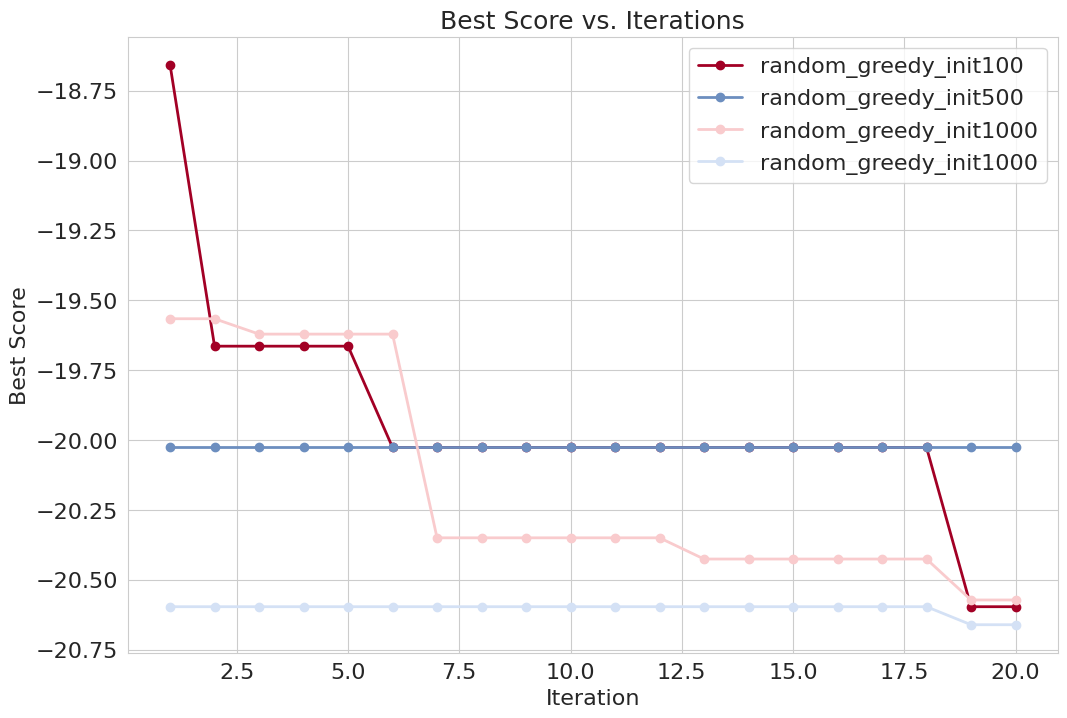

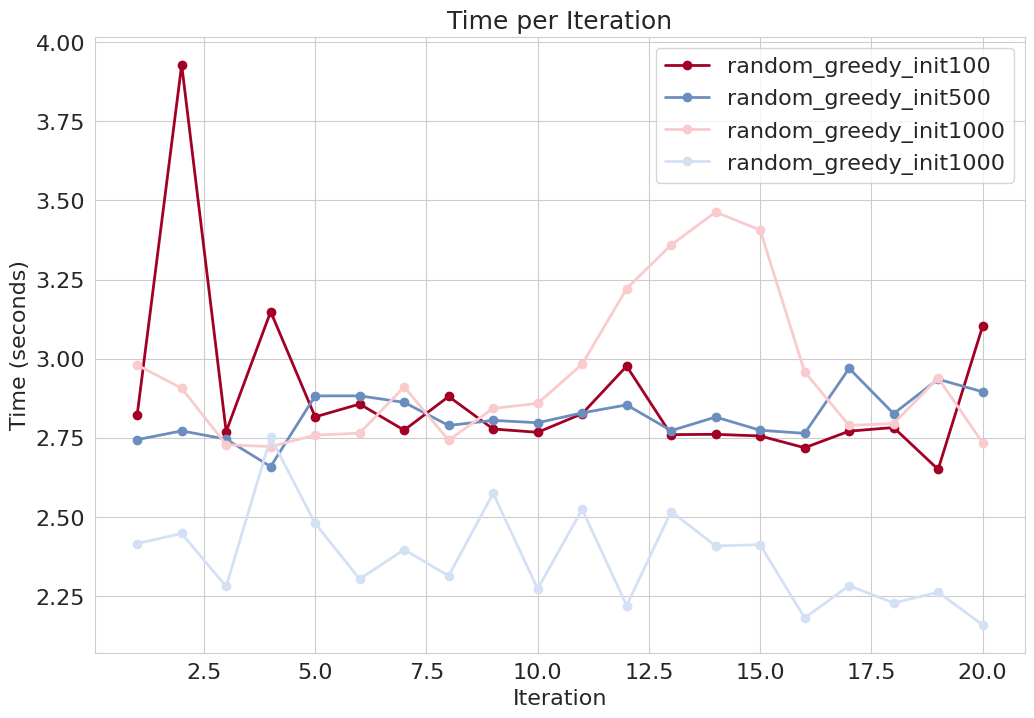

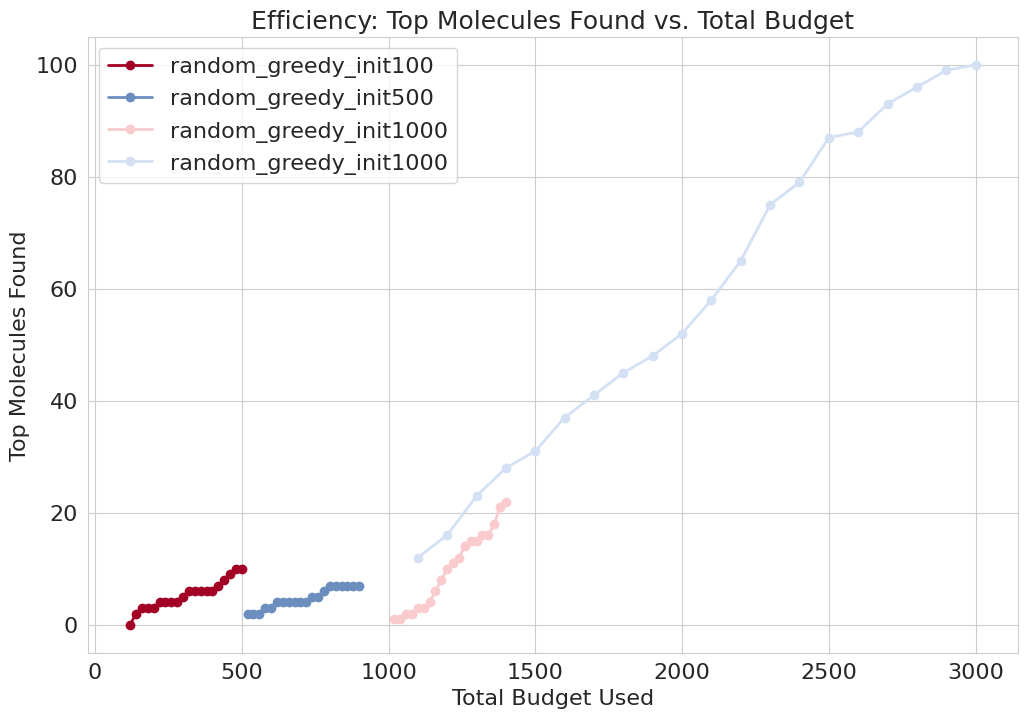

In [33]:
# Load data
print("Loading molecules from CSV...")
df = pd.read_csv(CSV_PATH)

# Identify top molecules for reference
top_100_df = df.nsmallest(100, 'r_i_docking_score')
top_100_smiles = set(top_100_df['SMILES'])

# Load molecular fingerprints
X_pool, smiles_pool = load_molecules(CSV_PATH)
print(f"Loaded {len(X_pool)} molecules")

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create experiment parameter grid
# Note: For a real experiment, you might want to start with a smaller grid
param_grid = {
    'n_initial_samples': [100, 500, 1000],
    'n_iterations': [20],
    'budget_per_iteration': [20, 50, 100],
    'initial_selection_method': ['random', 'diverse'],
    'acquisition_function': ['greedy', 'ei']
}

# Generate configurations
configs = create_experiment_configs(param_grid)
print(f"Created {len(configs)} experiment configurations")

# Initialize experiment manager
manager = ExperimentManager(
    base_dir=BASE_DIR,
    X_pool=X_pool,
    smiles_pool=smiles_pool,
    top_reference_smiles=top_100_smiles,
    device=device,
    oracle=deepdock_oracle,
    reference_df=df
)

# Run experiments
print("Starting experiments...")
results = manager.run_comparison(configs, parallel=False)

# Generate visualizations
print("Creating comparison plots...")
plots = manager.plot_results(results)

# Create summary table
print("Generating summary table...")
summary = manager.create_summary_table(results)
print(summary)

print(f"Experiment results saved to {BASE_DIR}")
print("Summary of experiments:")
for i, config in enumerate(configs):
    print(f"Experiment {i+1}: {config}")

## <b> <font color='#A20025'> 3️⃣ Free Energy Calculations: Active Learning for Lead Optimization

*This section does not contain accompanying code, though there is pseudocode referenced throughout the chapter text.*

## <b> <font color='#A20025'> Summary

In this chapter:
- We explored the integration of deep learning and active learning techniques in structure-based drug design to address the computational challenges of virtual screening in massive chemical spaces. We began by implementing a complete molecular docking workflow to understand the fundamentals of protein-ligand interactions, focusing on the EGFR target as our case study. This workflow demonstrated how to prepare protein and ligand structures, define binding sites, conduct docking simulations using AutoDock Vina, and analyze the resulting interaction fingerprints.
- We addressed a critical bottleneck in drug discovery: the prohibitive computational cost of exhaustively docking billions of potential compounds from modern Synthesis on Demand (SoD) libraries. To overcome this challenge, we implemented a deep docking approach using active learning, which strategically selects only the most promising compounds for full docking evaluation while using a surrogate model to estimate binding affinities for the remaining compounds.
- Our active learning implementation included several key components: a neural network surrogate model that learns to predict binding affinities from molecular fingerprints; strategic initial sampling methods to establish a diverse starting point; various acquisition functions (greedy, uncertainty sampling, probability of improvement, and expected improvement) that balance exploration and exploitation; an iterative learning loop that progressively refines the surrogate model with new data; and comprehensive experiment management tools for analyzing and comparing different active learning strategies.
- The results demonstrated that active learning can dramatically reduce the computational resources required for virtual screening while still identifying the most promising drug candidates. Our experiments with the VEGFR-2 kinase target (PDB ID: 4AG8) showed that only a small fraction of the compound library needed to be docked to identify virtually all of the top-scoring molecules.
- We explored how these active learning principles extend beyond docking to more computationally intensive methods like Free Energy Perturbation (FEP) calculations, which provide more accurate binding affinity predictions during lead optimization. We discussed how active learning can be used not only to prioritize which molecules undergo FEP evaluation but also to optimize the FEP protocols themselves.
- The techniques presented in this chapter provide a powerful framework for navigating the vast chemical space of potential drug compounds more efficiently, enabling exploration of billions of molecules with limited computational resources. By combining the physics-based understanding of molecular interactions with the pattern recognition capabilities of machine learning, structure-based drug design can become more efficient and effective in identifying promising drug candidates.


### <b> <font color='#A20025'> Extra Code

Below is a helper function for processing and aggregate a subset of the Deep Dock data set into a single file for 4AG8.

In [ ]:
import glob

def aggregate_and_sample_csvs(root_folder, output_file, n_top=5000, n_bottom=5000, n_middle=40000):
    """
    Aggregate CSV files from iteration subfolders and sample specific numbers of entries
    based on r_i_docking_score.
    
    Args:
        root_folder (str): Path to the root folder (e.g., 4AG8)
        output_file (str): Path to save the output CSV
        n_top (int): Number of top scoring entries to include
        n_bottom (int): Number of bottom scoring entries to include
        n_middle (int): Number of random entries to sample from the middle
    """
    # Find all CSV files in iteration subfolders
    csv_pattern = os.path.join(root_folder, "iteration_*", "*.csv")
    csv_files = glob.glob(csv_pattern)
    
    if not csv_files:
        raise ValueError(f"No CSV files found in {root_folder}")
    
    print(f"Found {len(csv_files)} CSV files")
    
    # Read and concatenate all CSV files
    dfs = []
    for file in csv_files:
        try:
            df = pd.read_csv(file)
            required_columns = ["r_i_docking_score", "ZINC_ID", "SMILES"]
            if not all(col in df.columns for col in required_columns):
                print(f"Warning: Skipping {file} - missing required columns")
                continue
            dfs.append(df)
        except Exception as e:
            print(f"Error reading {file}: {str(e)}")
            continue
    
    if not dfs:
        raise ValueError("No valid CSV files were read")
    
    # Combine all dataframes
    combined_df = pd.concat(dfs, ignore_index=True)
    print(f"Total entries: {len(combined_df)}")
    
    # Sort by docking score
    sorted_df = combined_df.sort_values('r_i_docking_score')
    
    # Get top and bottom entries
    top_entries = sorted_df.head(n_top)
    bottom_entries = sorted_df.tail(n_bottom)
    
    # Get middle entries (excluding top and bottom)
    middle_df = sorted_df.iloc[n_top:-n_bottom]
    
    # Randomly sample from middle
    if len(middle_df) < n_middle:
        print(f"Warning: Only {len(middle_df)} entries available for middle sampling")
        middle_sample = middle_df
    else:
        middle_sample = middle_df.sample(n=n_middle, random_state=42)
    
    # Combine the samples
    final_df = pd.concat([top_entries, middle_sample, bottom_entries])
    
    # Save to CSV
    final_df.to_csv(output_file, index=False)
    
    print(f"\nSummary:")
    print(f"Top entries (lowest scores): {len(top_entries)}")
    print(f"Random middle entries: {len(middle_sample)}")
    print(f"Bottom entries (highest scores): {len(bottom_entries)}")
    print(f"Total entries in output: {len(final_df)}")
    print(f"\nScore ranges:")
    print(f"Top scores: {final_df['r_i_docking_score'].min():.2f} to {top_entries['r_i_docking_score'].max():.2f}")
    print(f"Middle scores: {middle_sample['r_i_docking_score'].min():.2f} to {middle_sample['r_i_docking_score'].max():.2f}")
    print(f"Bottom scores: {bottom_entries['r_i_docking_score'].min():.2f} to {final_df['r_i_docking_score'].max():.2f}")

# Usage example
root_folder = "4AG8"
output_file = "aggregated_samples.csv"
aggregate_and_sample_csvs(root_folder, output_file)

The following are additional helper functions to aid in contniued analysis of the ExperimentManager's results. These are not guaranteed to be updated at the same cadence as the core chapter code and may be out of sync at any given point.

In [ ]:
def analyze_learning_curves(results, save_dir=None):
    """
    Analyze the learning curves from the active learning experiments.
    
    Args:
        results (dict): Dictionary mapping experiment IDs to results DataFrames
        save_dir (str, optional): Directory to save plots
        
    Returns:
        dict: Dictionary of figure objects
    """
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
    
    figures = {}
    
    # Calculate average performance across experiments
    combined_data = []
    for exp_id, df in results.items():
        config_path = os.path.join(os.path.dirname(save_dir), exp_id, "config.json")
        config = {}
        if os.path.exists(config_path):
            with open(config_path, 'r') as f:
                config = json.load(f)
        
        # Add experiment identifiers
        df = df.copy()
        df['exp_id'] = exp_id
        df['n_initial_samples'] = config.get('n_initial_samples', 'N/A')
        df['acquisition_function'] = config.get('acquisition_function', 'N/A')
        df['initial_selection_method'] = config.get('initial_selection_method', 'N/A')
        
        combined_data.append(df)
    
    if not combined_data:
        return figures
    
    combined_df = pd.concat(combined_data, ignore_index=True)
    
    # 1. Learning rate plots (how quickly do different strategies improve)
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Group by acquisition function
    for acq_func, group in combined_df.groupby('acquisition_function'):
        # Calculate mean and std error for each iteration
        stats = group.groupby('iteration')['top_molecules_found'].agg(['mean', 'std']).reset_index()
        
        # Plot mean with error bands
        ax.plot(stats['iteration'], stats['mean'], marker='o', linewidth=2, label=acq_func)
        ax.fill_between(
            stats['iteration'], 
            stats['mean'] - stats['std'], 
            stats['mean'] + stats['std'],
            alpha=0.2
        )
    
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Top Molecules Found')
    ax.set_title('Learning Curves by Acquisition Function')
    ax.legend(loc='best')
    ax.grid(True)
    
    figures['learning_curves_by_acq'] = fig
    
    if save_dir:
        plt.savefig(os.path.join(save_dir, 'learning_curves_by_acq.png'), dpi=300, bbox_inches='tight')
    
    # 2. Efficiency comparison (top molecules per evaluation)
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Group by initial selection method
    for init_method, group in combined_df.groupby('initial_selection_method'):
        # Calculate efficiency
        group = group.copy()
        group['efficiency'] = group['top_molecules_found'] / group['total_molecules']
        
        # Calculate mean and std error for each iteration
        stats = group.groupby('iteration')['efficiency'].agg(['mean', 'std']).reset_index()
        
        # Plot mean with error bands
        ax.plot(stats['iteration'], stats['mean'], marker='o', linewidth=2, label=init_method)
        ax.fill_between(
            stats['iteration'], 
            stats['mean'] - stats['std'], 
            stats['mean'] + stats['std'],
            alpha=0.2
        )
    
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Efficiency (Top Molecules / Total Evaluations)')
    ax.set_title('Efficiency by Initial Selection Method')
    ax.legend(loc='best')
    ax.grid(True)
    
    figures['efficiency_by_init'] = fig
    
    if save_dir:
        plt.savefig(os.path.join(save_dir, 'efficiency_by_init.png'), dpi=300, bbox_inches='tight')
    
    return figures

def analyze_factor_importance(summary_df, target_metric='final_top_molecules_found'):
    """
    Analyze the importance of different factors on the target metric.
    
    Args:
        summary_df (pd.DataFrame): Summary table from experiments
        target_metric (str): Target metric to analyze
        
    Returns:
        pd.DataFrame: DataFrame with factor importance scores
    """
    # Identify factors (parameters) in the summary data
    factors = ['n_initial_samples', 'initial_selection_method', 
               'acquisition_function', 'budget_per_iteration', 'n_iterations']
    
    # Calculate the mean performance for each factor level
    factor_importance = {}
    
    for factor in factors:
        if factor in summary_df.columns:
            # Group by the factor and calculate mean performance
            grouped = summary_df.groupby(factor)[target_metric].mean().reset_index()
            
            # Calculate the range of performance (max - min)
            performance_range = grouped[target_metric].max() - grouped[target_metric].min()
            
            factor_importance[factor] = {
                'importance_score': performance_range,
                'best_value': grouped.loc[grouped[target_metric].idxmax(), factor],
                'mean_performance': grouped[target_metric].mean()
            }
    
    # Convert to DataFrame
    importance_df = pd.DataFrame.from_dict(factor_importance, orient='index')
    importance_df = importance_df.sort_values('importance_score', ascending=False)
    
    return importance_df

def plot_factor_importance(importance_df, save_path=None):
    """
    Plot the importance of different factors.
    
    Args:
        importance_df (pd.DataFrame): Factor importance DataFrame
        save_path (str, optional): Path to save the plot
        
    Returns:
        plt.Figure: The figure object
    """
    plt.figure(figsize=(12, 8))
    
    # Create bar plot
    sns.barplot(x=importance_df.index, y='importance_score', data=importance_df)
    
    plt.title('Factor Importance for Performance')
    plt.xlabel('Factor')
    plt.ylabel('Importance Score (Range of Performance)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
    return plt.gcf()

def calculate_experiment_diversity(results, exp_ids=None, base_dir=None):
    """
    Calculate and visualize the diversity of experiment configurations.
    
    Args:
        results (dict): Dictionary mapping experiment IDs to results DataFrames
        exp_ids (list, optional): List of experiment IDs to analyze
        base_dir (str, optional): Base directory containing experiment data
        
    Returns:
        plt.Figure: The figure object
    """
    if exp_ids is None:
        exp_ids = list(results.keys())
    
    # Extract configurations for each experiment
    configs = []
    for exp_id in exp_ids:
        if base_dir is not None:
            config_path = os.path.join(base_dir, exp_id, "config.json")
            if os.path.exists(config_path):
                with open(config_path, 'r') as f:
                    config = json.load(f)
                configs.append(config)
    
    if not configs:
        return None
    
    # Convert configurations to feature matrix
    # We need to one-hot encode categorical variables
    features = []
    feature_names = []
    
    # Identify all possible parameter values
    param_values = {}
    for config in configs:
        for param, value in config.items():
            if param not in param_values:
                param_values[param] = set()
            param_values[param].add(value)
    
    # Create feature matrix
    for config in configs:
        feature_vector = []
        for param, values in param_values.items():
            # For categorical parameters
            if param in ['initial_selection_method', 'acquisition_function']:
                for value in values:
                    feature_vector.append(1 if config.get(param) == value else 0)
                    feature_names.append(f"{param}_{value}")
            # For numerical parameters
            else:
                value = config.get(param, 0)
                feature_vector.append(float(value))
                feature_names.append(param)
        
        features.append(feature_vector)
    
    # Convert to numpy array
    features = np.array(features)
    
    # Normalize features
    features_normalized = (features - features.mean(axis=0)) / (features.std(axis=0) + 1e-10)
    
    # Apply PCA for visualization
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features_normalized)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot points
    ax.scatter(features_pca[:, 0], features_pca[:, 1], s=100, alpha=0.7)
    
    # Add experiment IDs as labels
    for i, exp_id in enumerate(exp_ids[:len(features_pca)]):
        ax.annotate(exp_id, (features_pca[i, 0], features_pca[i, 1]), 
                   fontsize=9, ha='center', va='center')
    
    ax.set_xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax.set_ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    ax.set_title('Experiment Configuration Diversity')
    ax.grid(True)
    
    return fig

def create_interaction_plots(summary_df, factor1, factor2, target_metric='final_top_molecules_found', save_path=None):
    """
    Create interaction plots between two factors.
    
    Args:
        summary_df (pd.DataFrame): Summary table from experiments
        factor1 (str): First factor to analyze
        factor2 (str): Second factor to analyze
        target_metric (str): Target metric to analyze
        save_path (str, optional): Path to save the plot
        
    Returns:
        plt.Figure: The figure object
    """
    if factor1 not in summary_df.columns or factor2 not in summary_df.columns:
        print(f"Error: {factor1} or {factor2} not found in summary DataFrame")
        return None
    
    # Create pivot table
    try:
        pivot = summary_df.pivot_table(index=factor1, columns=factor2, values=target_metric, aggfunc='mean')
        
        # Create heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot, annot=True, cmap='YlGnBu', fmt='.2f')
        
        plt.title(f'Interaction between {factor1} and {factor2} on {target_metric}')
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            
        return plt.gcf()
    except Exception as e:
        print(f"Error creating interaction plot: {e}")
        return None

Run the analysis

Loading experiments from artifacts/ch09/al_experiments
Loaded 4 experiments
Created summary table: artifacts/ch09/al_experiments/summary_table.csv
Analyzing factor importance...
Created factor importance plot: artifacts/ch09/al_experiments/factor_importance.png
Creating interaction plot for budget_per_iteration and n_initial_samples...
Created interaction plot: artifacts/ch09/al_experiments/interaction_budget_per_iteration_n_initial_samples.png
Analyzing learning curves...
Analyzing experiment diversity...
Created experiment diversity plot: artifacts/ch09/al_experiments/experiment_diversity.png
Analysis completed. Results saved to artifacts/ch09/al_experiments


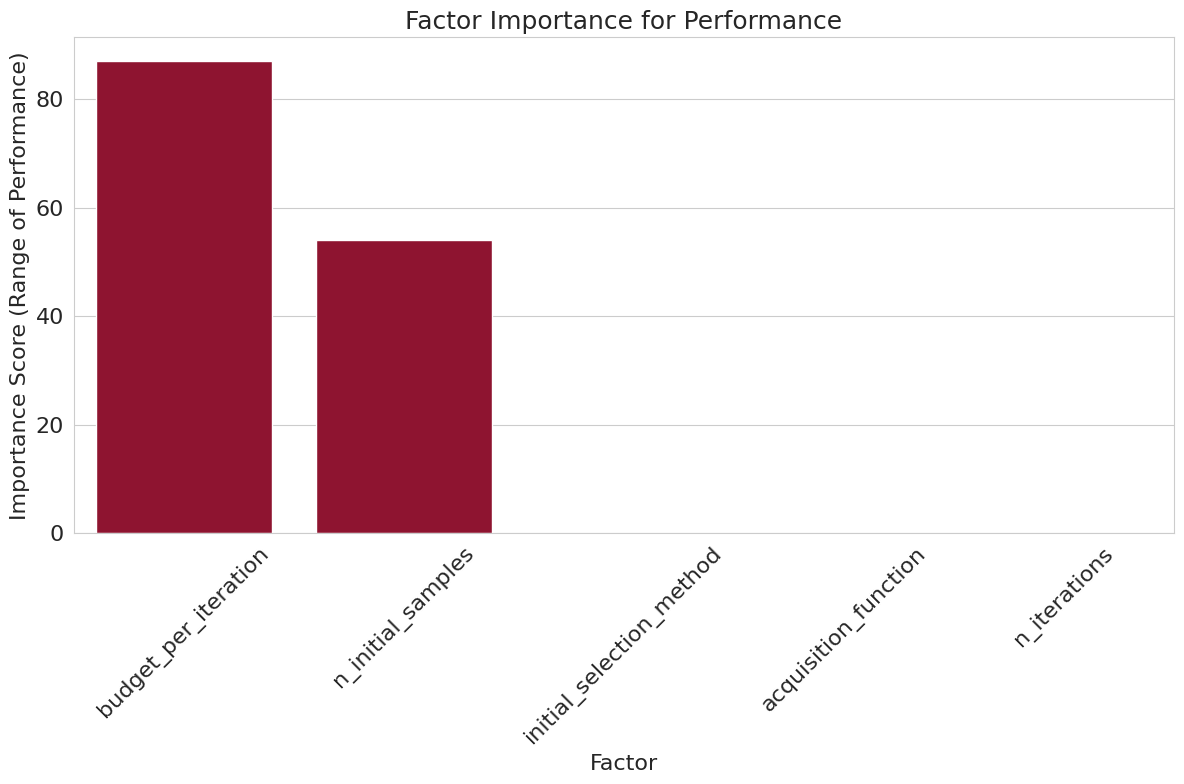

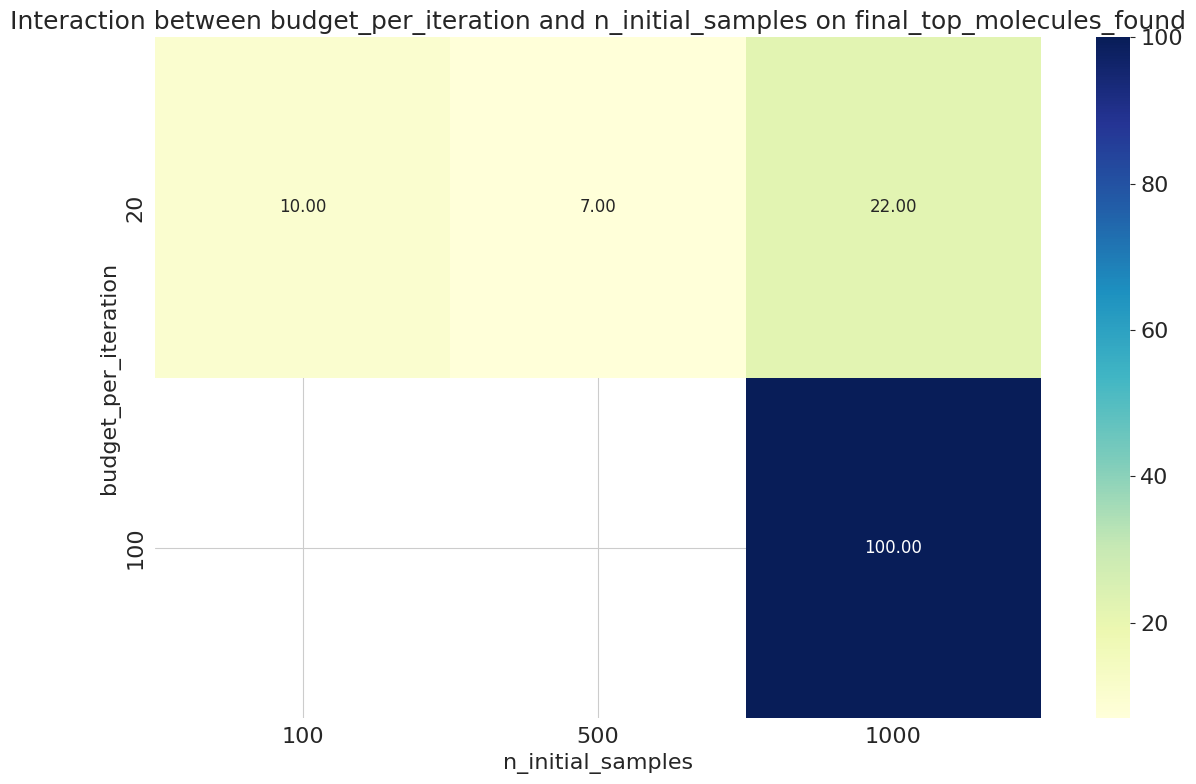

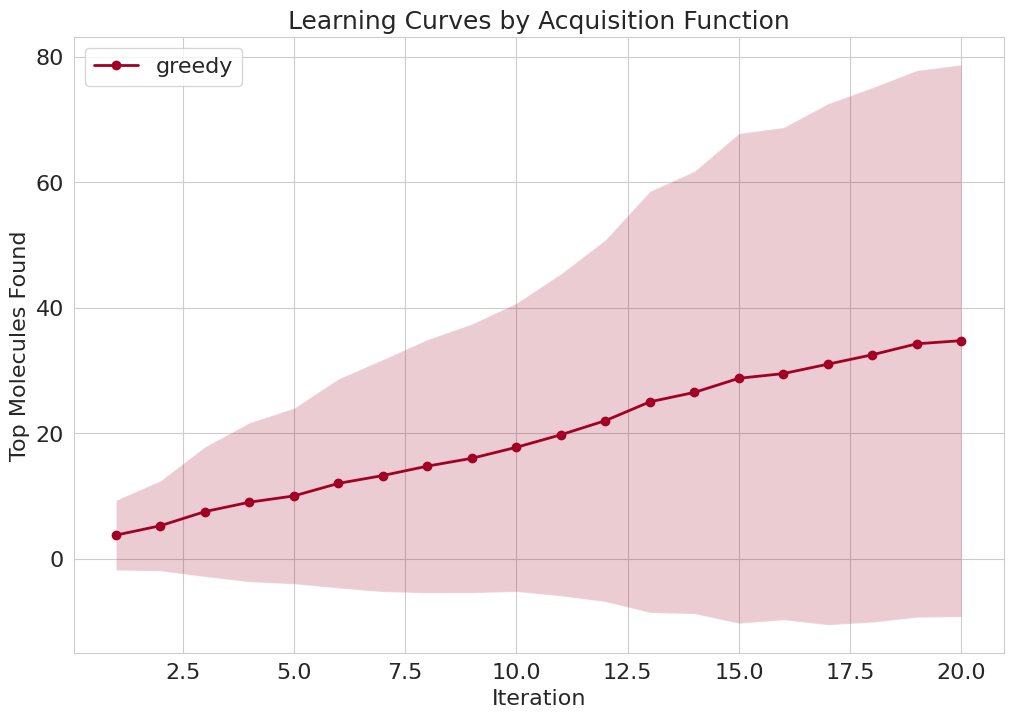

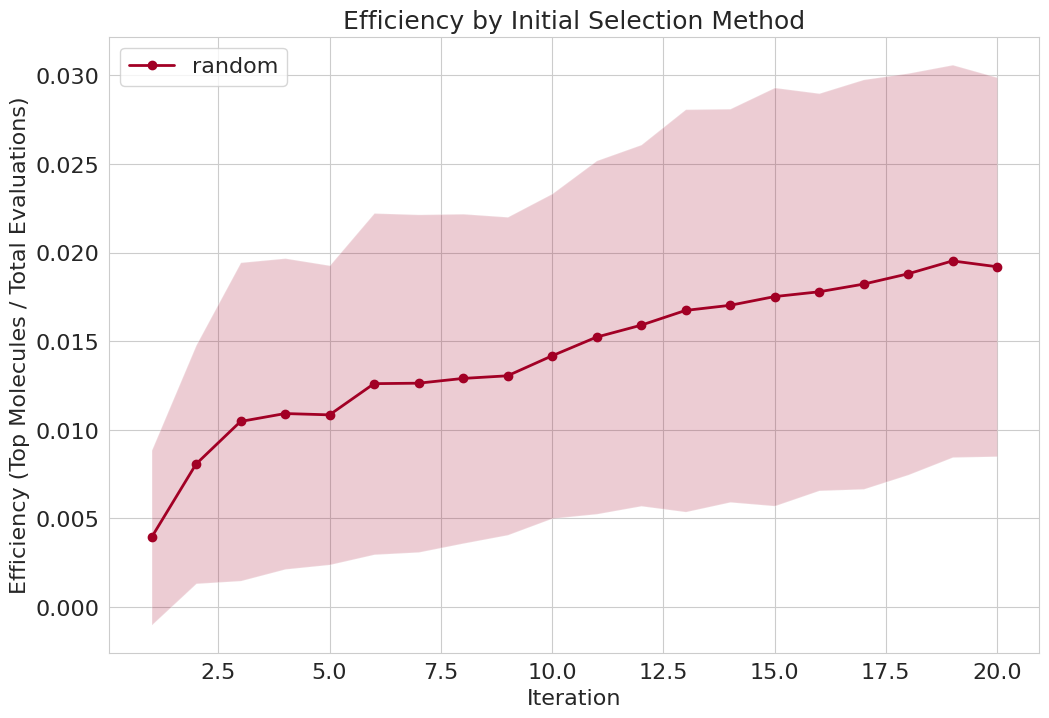

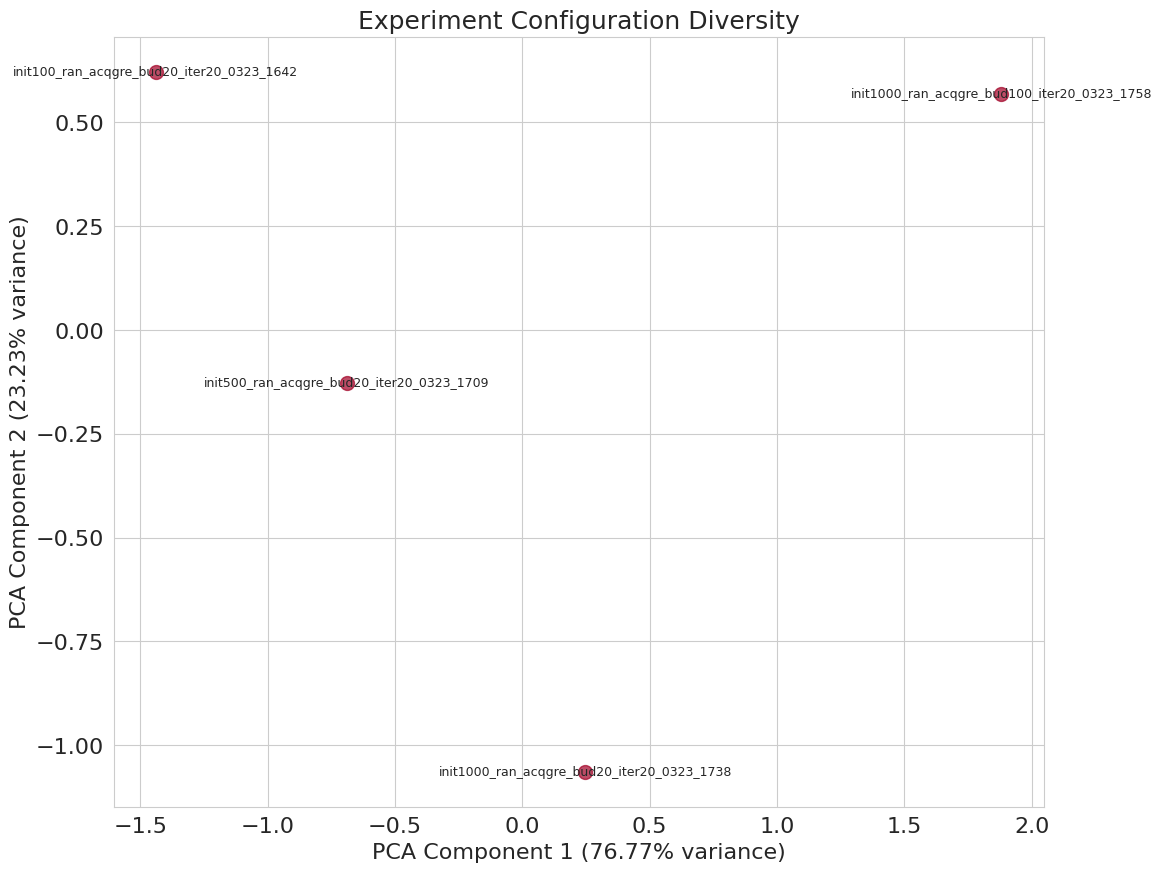

In [ ]:
from sklearn.decomposition import PCA

EXP_DIR = "artifacts/ch09/al_experiments"
OUT_DIR = "artifacts/ch09/al_experiments"
os.makedirs(OUT_DIR, exist_ok=True)

print(f"Loading experiments from {EXP_DIR}")

# Load experiment manager
manager = ExperimentManager(base_dir=EXP_DIR)

# Load experiment results
results = manager.load_experiments()
if not results:
    print("No experiment results found.")

print(f"Loaded {len(results)} experiments")

# Create summary table
summary_df = manager.create_summary_table(results)
summary_path = os.path.join(OUT_DIR, 'summary_table.csv')
summary_df.to_csv(summary_path, index=False)
print(f"Created summary table: {summary_path}")

# Analyze factor importance
print("Analyzing factor importance...")
importance_df = analyze_factor_importance(summary_df)
importance_path = os.path.join(OUT_DIR, 'factor_importance.csv')
importance_df.to_csv(importance_path)

# Plot factor importance
plot_path = os.path.join(OUT_DIR, 'factor_importance.png')
plot_factor_importance(importance_df, save_path=plot_path)
print(f"Created factor importance plot: {plot_path}")

# Create interaction plots for the most important factors
if len(importance_df) >= 2:
    top_factors = importance_df.index.tolist()[:2]
    print(f"Creating interaction plot for {top_factors[0]} and {top_factors[1]}...")
    interaction_path = os.path.join(OUT_DIR, f'interaction_{top_factors[0]}_{top_factors[1]}.png')
    create_interaction_plots(summary_df, top_factors[0], top_factors[1], save_path=interaction_path)
    print(f"Created interaction plot: {interaction_path}")

# Analyze learning curves
print("Analyzing learning curves...")
learning_curves_dir = os.path.join(OUT_DIR, 'learning_curves')
analyze_learning_curves(results, save_dir=learning_curves_dir)

# Calculate experiment diversity
print("Analyzing experiment diversity...")
diversity_fig = calculate_experiment_diversity(results, base_dir=EXP_DIR)
if diversity_fig:
    diversity_path = os.path.join(OUT_DIR, 'experiment_diversity.png')
    diversity_fig.savefig(diversity_path, dpi=300, bbox_inches='tight')
    print(f"Created experiment diversity plot: {diversity_path}")

print(f"Analysis completed. Results saved to {OUT_DIR}")